## 0. Setup

In [8]:
import numpy as np
import pandas as pd
import shap
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor, LGBMClassifier, plot_tree
import warnings
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from scipy import stats 

import preprocessing as pp
import train_test_sets

warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 200

mri_subs_path = "/home/brunovieira/backup/Tamires_Experiments/Bases_de_Dados/MRI_Data_Voxels_894.parquet" 
mri_areas_path = "/home/brunovieira/backup/Tamires_Experiments/Bases_de_Dados/MRI_Data_Areas_890.csv" 
bb_path = "/home/brunovieira/backup/Tamires_Experiments/Bases_de_Dados/BigBrain.xlsx"
ids_path = "/home/brunovieira/backup/Tamires_Experiments/Bases_de_Dados/participants_nkienhanced.tsv"

In [10]:
# read df
df = pd.read_parquet("/home/brunovieira/backup/Tamires_Experiments/Bases_de_Dados/MRI_2_anualrate_894.parquet") 
df[['hemisphere','atlasEcono', 'handedness','sex', 'age']] = df[['hemisphere','atlasEcono', 'handedness','sex', 'age']].astype('int32')

#add macro areas
Dict_structures = pd.read_csv('/home/brunovieira/backup/Tamires_Experiments/Bases_de_Dados/Dict_structures.csv', sep=';', header=None)
df = df.merge(Dict_structures, how='left', left_on='atlasEcono', right_on=0)
df = df.rename(columns = {1:'macro_area', 2:'name'})
df = df.drop(columns=0)

# add bigbrain features
df = pp.bb_features(bb_path, df)
df = df.dropna()

# show
df

participant  hemisphere  atlasEcono      area      curv      sulc  \
1       A00008326           0          10  0.674312 -0.071932 -0.772772   
2       A00008326           0          11  0.671304 -0.113367 -3.917485   
3       A00008326           0          12  0.657484 -0.031216  0.759638   
4       A00008326           0          13  0.660866  0.057810  4.836751   
9       A00008326           0          18  0.672671  0.004583  6.243018   
...           ...         ...         ...       ...       ...       ...   
76570   A00074034           1           5  0.713598 -0.076459 -2.321757   
76571   A00074034           1           6  0.696133 -0.052322 -0.856248   
76572   A00074034           1           7  0.696301 -0.030132 -0.018164   
76573   A00074034           1           8  0.715311 -0.045140  3.215669   
76574   A00074034           1           9  0.683810 -0.087782 -2.993106   

       thickness  age  sex  handedness  ... bblayer3_age  bblayer4_age  \
1       2.511595   59    0           2  ...    16.465117      3.887597   
2       2.039412   59    0           2  ...    15.751132      4.271493   
3       2.238305   59    0           2  ...    16.623016      4.448413   
4       3.139344   59    0           2  ...    16.469965      3.335689   
9       3.035824   59    0           2  ...    16.255102      3.210884   
...          ...  ...  ...         ...  ...          ...           ...   
76570   3.034636   10    0           2  ...     2.804428      0.627306   
76571   2.932701   10    0           2  ...     2.755905      0.708661   
76572   2.758097   10    0           2  ...     2.738095      0.714286   
76573   2.809121   10    0           2  ...     2.867384      0.645161   
76574   2.977603   10    0           2  ...     2.727273      0.785124   

      bblayer5_age bblayer6_age   ve1_age   ve2_age    ve3_age   ve4_age  \
1        13.034883    14.406977  6.020408  2.006803  20.068027  1.003401   
2        12.547511    13.615385  5.870647  4.696517   9.393035  5.283582   
3        11.940476    12.642858  5.453782  2.726891  16.857143  3.718488   
4        13.551237    13.968198  4.246787  1.213368  27.300770  0.758355   
9        13.244898    14.047619  4.478548  1.947195  13.630363  2.920792   
...            ...          ...       ...       ...        ...       ...   
76570     2.287823     2.398524  0.808081  0.606061   3.367003  0.572391   
76571     2.125984     2.401575  0.719424  0.683453   2.877698  0.863309   
76572     2.142857     2.460317  0.981132  0.754717   3.056604  0.943396   
76573     2.293907     2.365591  0.817121  0.544747   3.540856  0.856031   
76574     2.231405     2.355372  0.928270  0.632911   2.531646  1.265823   

         ve5_age    ve6_age  
1      12.442177  17.459185  
2      10.273632  23.482588  
3      10.411765  19.831934  
4       9.403599  16.077120  
9      12.656766  23.366337  
...          ...        ...  
76570   1.447811   3.198653  
76571   1.618705   3.237410  
76572   1.320755   2.943396  
76573   1.517510   2.723735  
76574   1.687764   2.953587  

[66123 rows x 44 columns]

In [11]:
df.columns

Index(['participant', 'hemisphere', 'atlasEcono', 'area', 'curv', 'sulc',
       'thickness', 'age', 'sex', 'handedness', 'h_structure', 'macro_area',
       'name', 'structure', 've_1', 've_2', 've_3', 've_4', 've_5', 've_6',
       'bigbrain_layer_1', 'bigbrain_layer_2', 'bigbrain_layer_3',
       'bigbrain_layer_4', 'bigbrain_layer_5', 'bigbrain_layer_6',
       'bigbrain_layer_1_r', 'bigbrain_layer_2_r', 'bigbrain_layer_3_r',
       'bigbrain_layer_4_r', 'bigbrain_layer_5_r', 'bigbrain_layer_6_r',
       'bblayer1_age', 'bblayer2_age', 'bblayer3_age', 'bblayer4_age',
       'bblayer5_age', 'bblayer6_age', 've1_age', 've2_age', 've3_age',
       've4_age', 've5_age', 've6_age'],
      dtype='object')

In [12]:
len(df.participant.unique())

871

-------------------

## 1. Regressao Polinomial e Derivada da Espessura

100%|██████████| 76/76 [00:05<00:00, 13.08it/s]


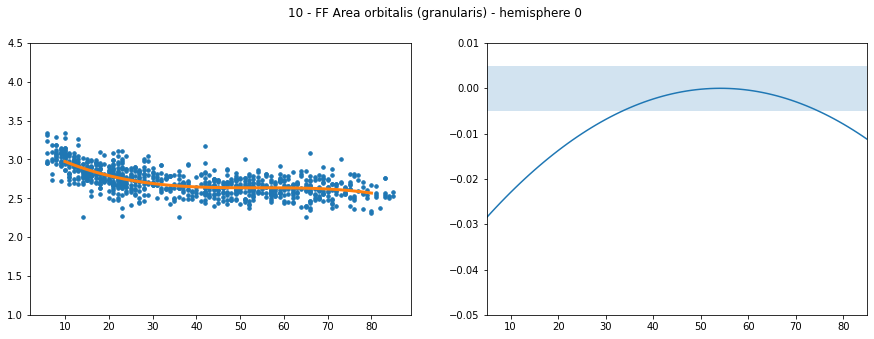

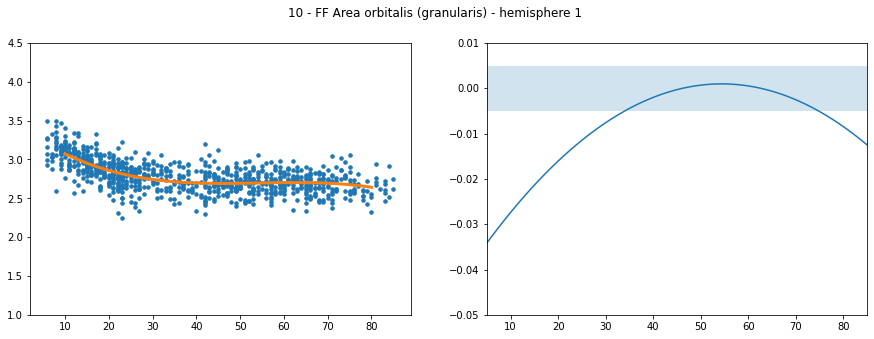

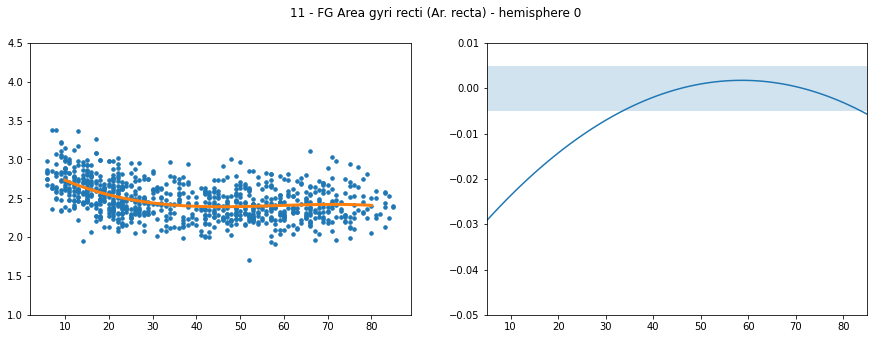

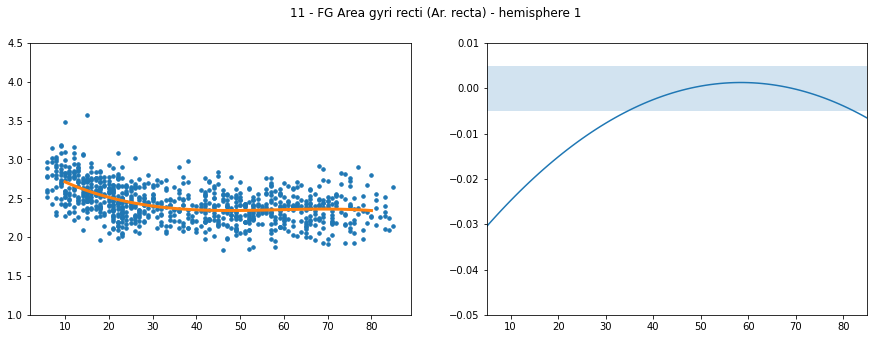

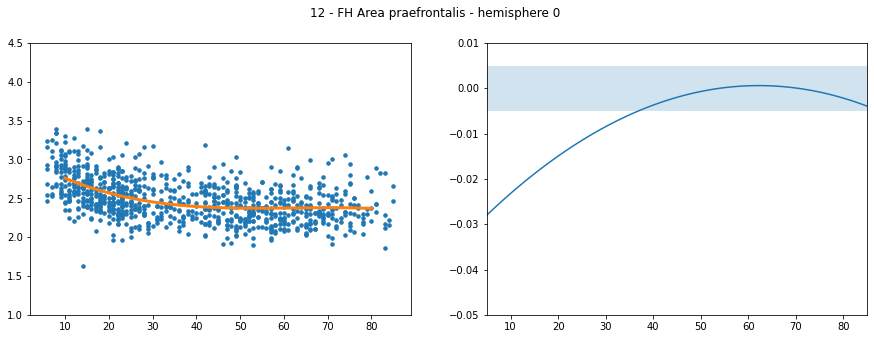

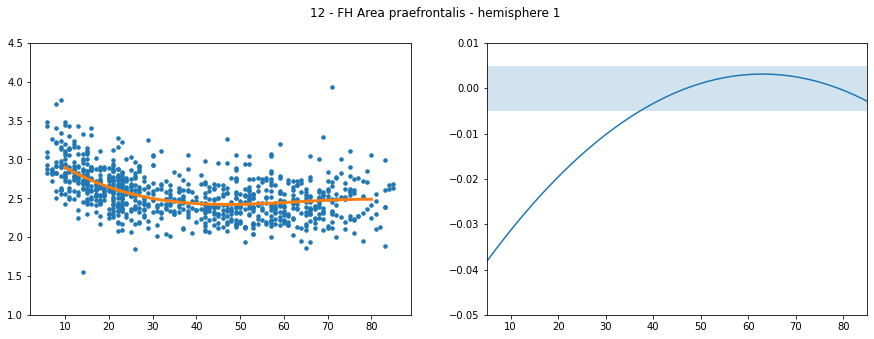

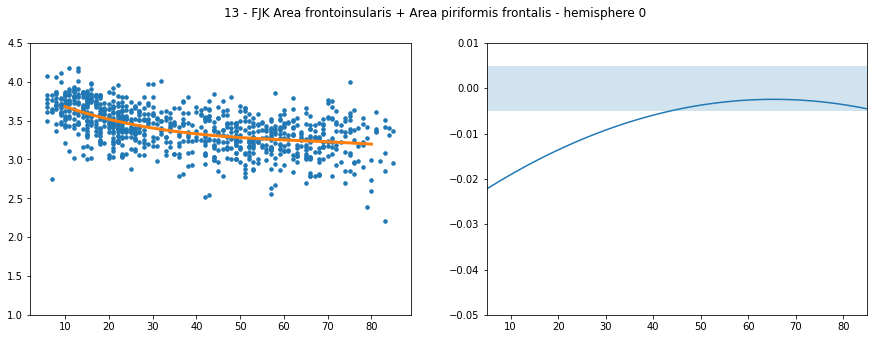

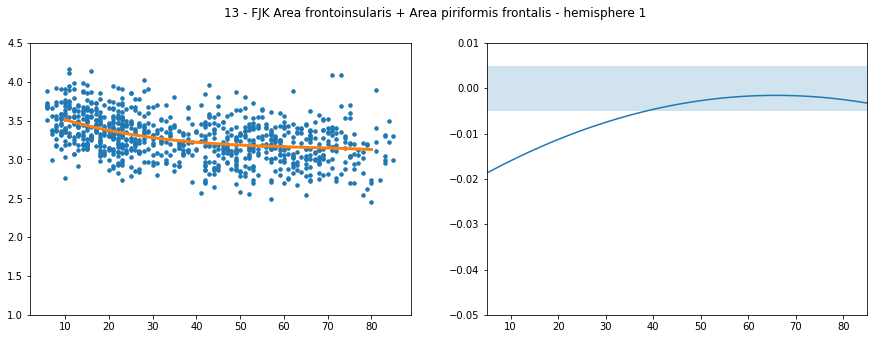

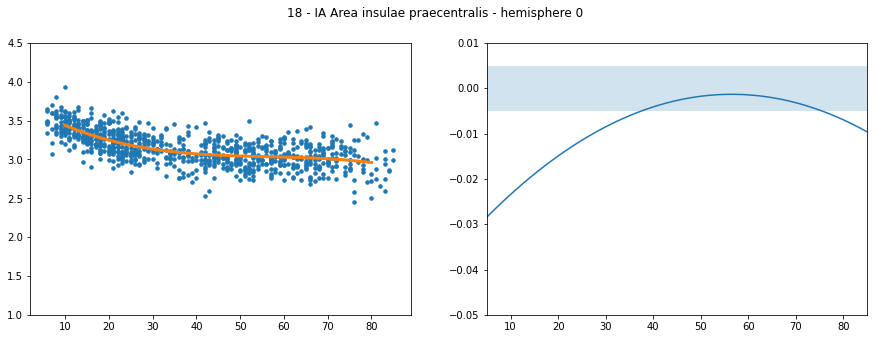

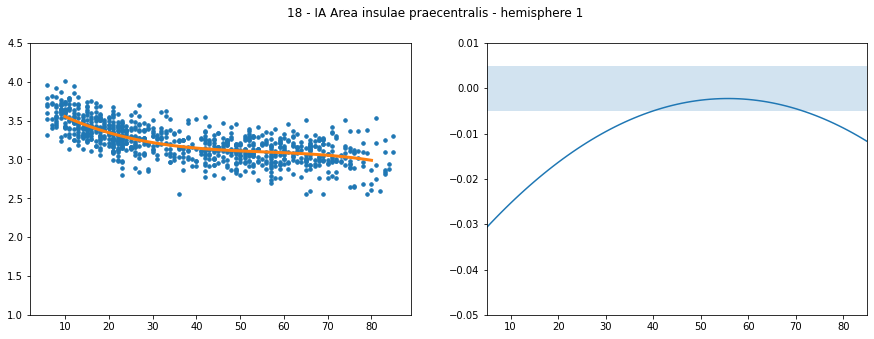

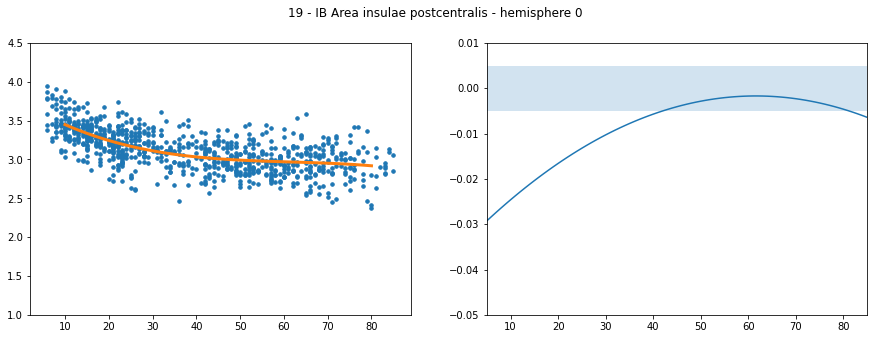

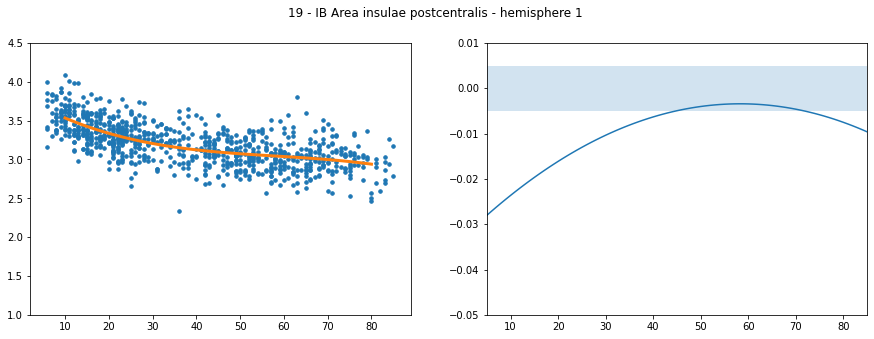

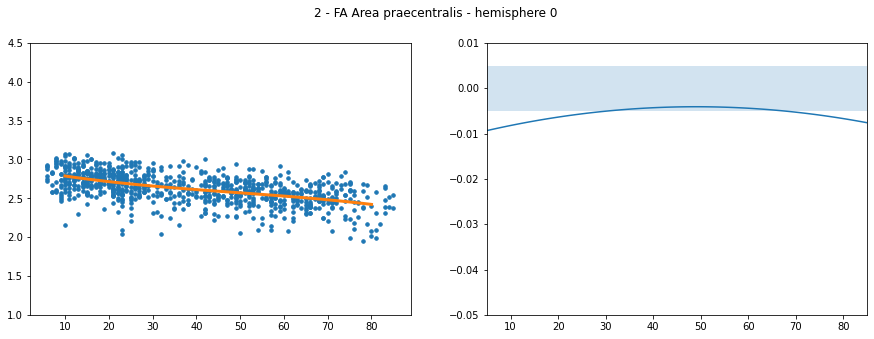

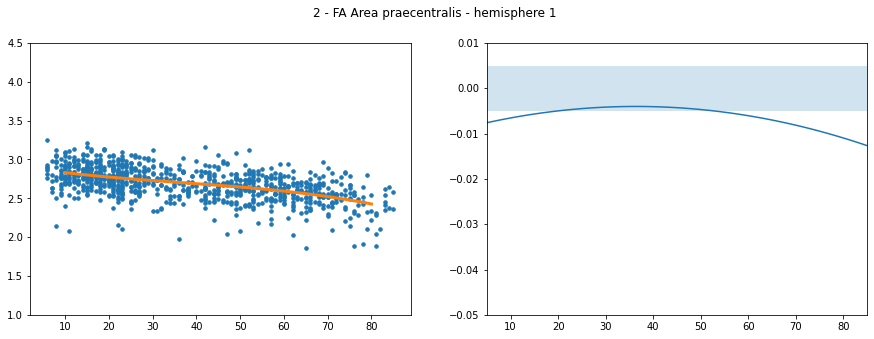

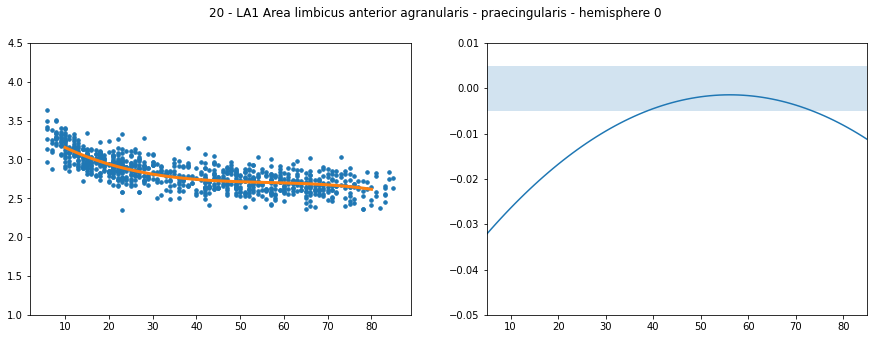

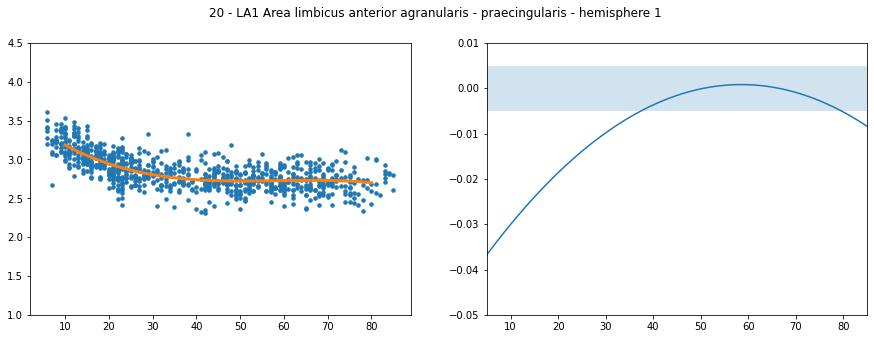

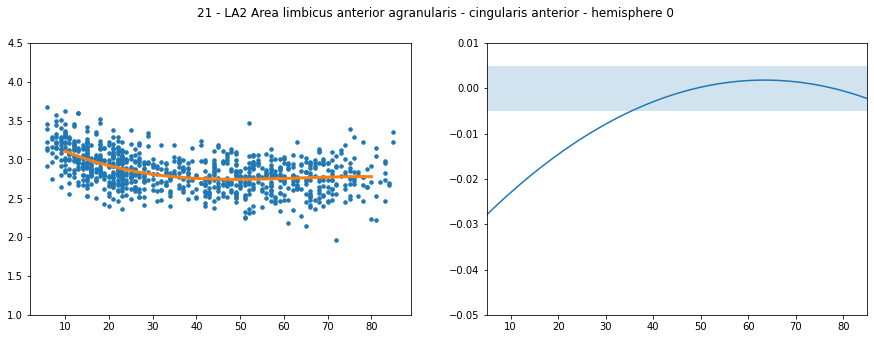

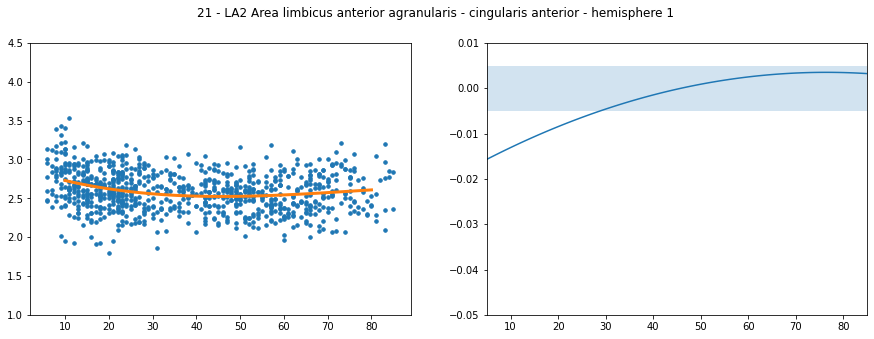

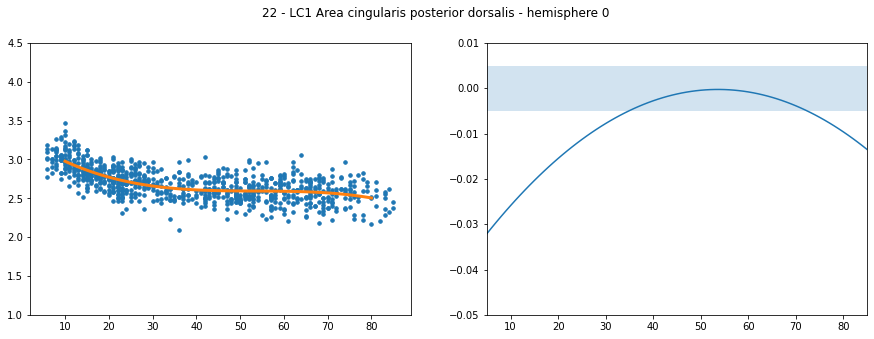

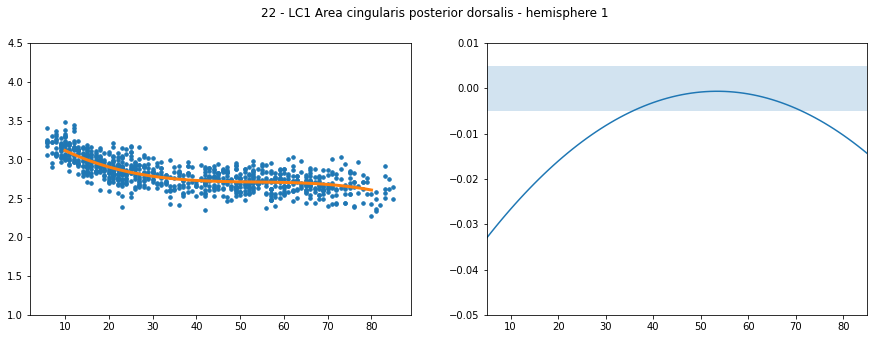

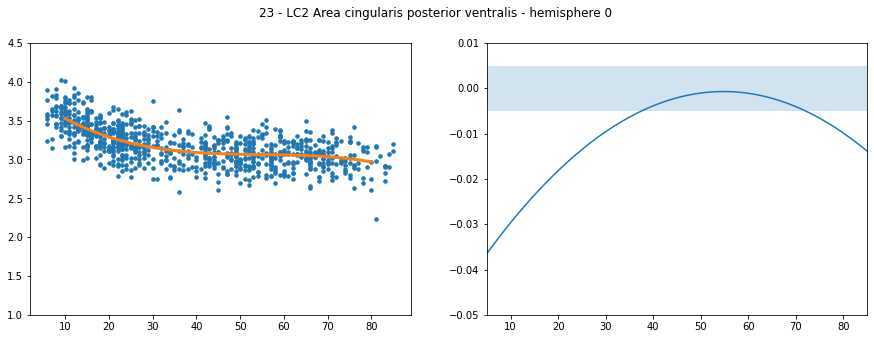

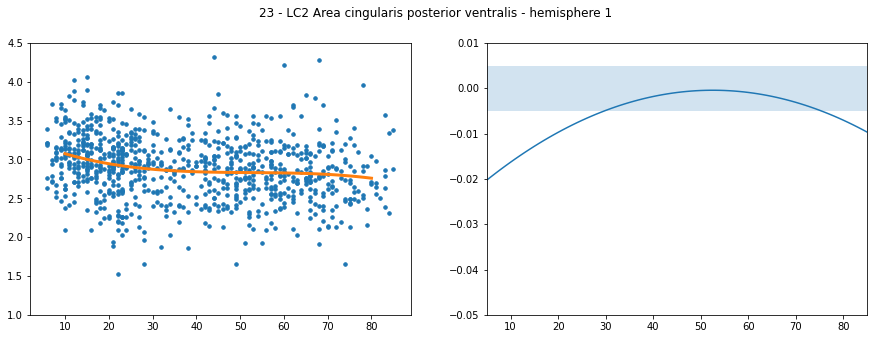

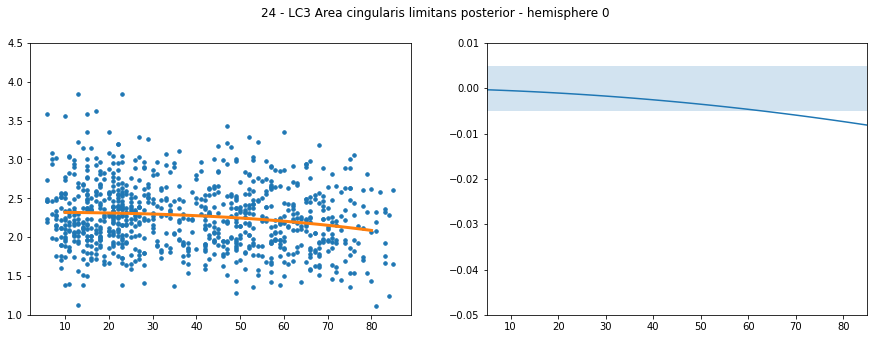

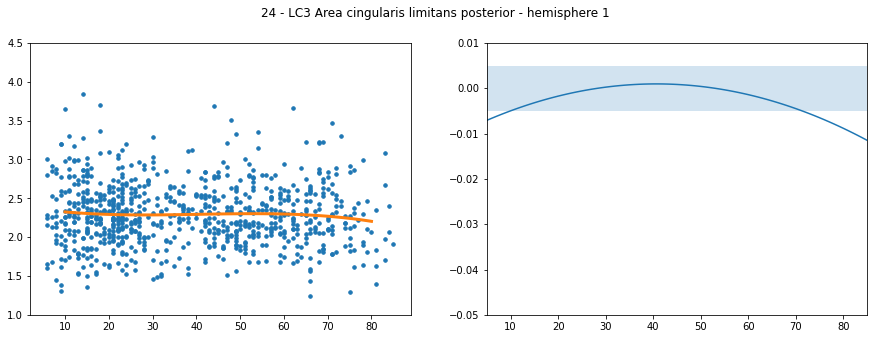

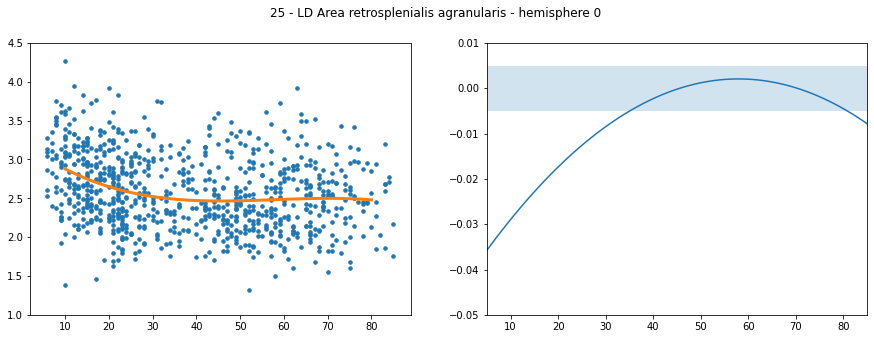

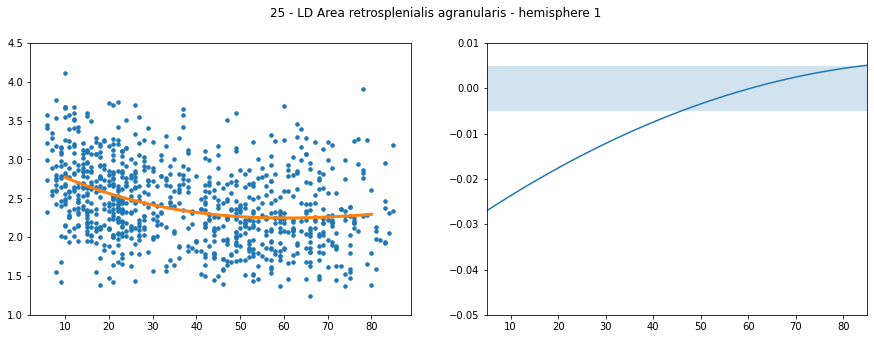

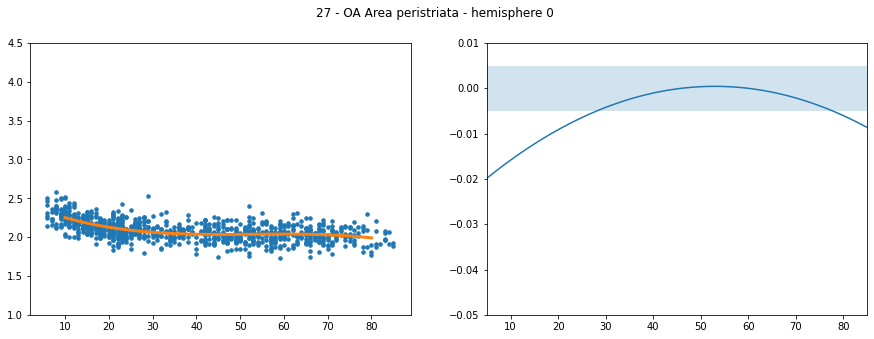

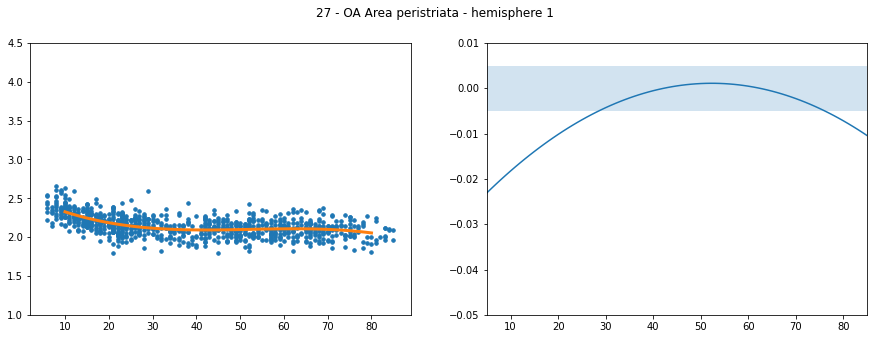

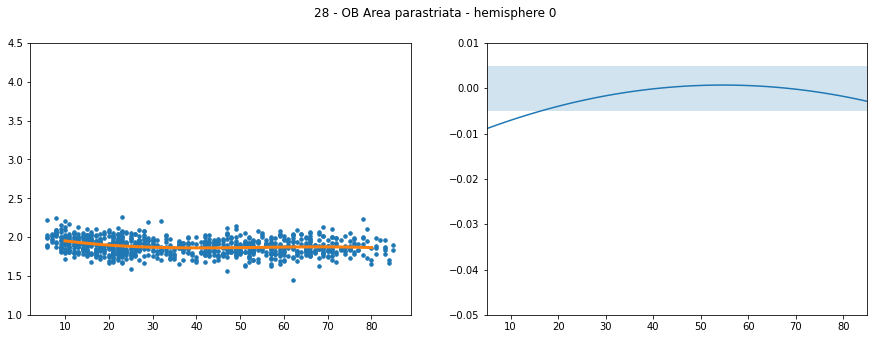

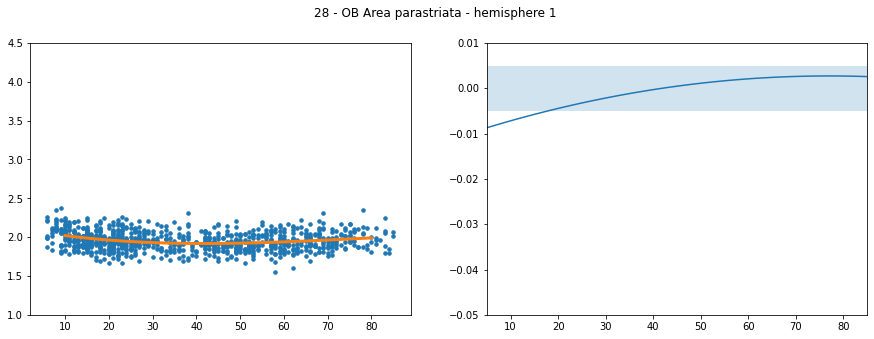

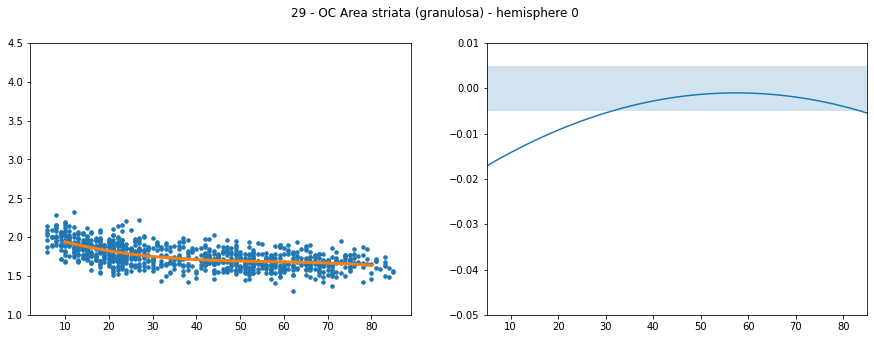

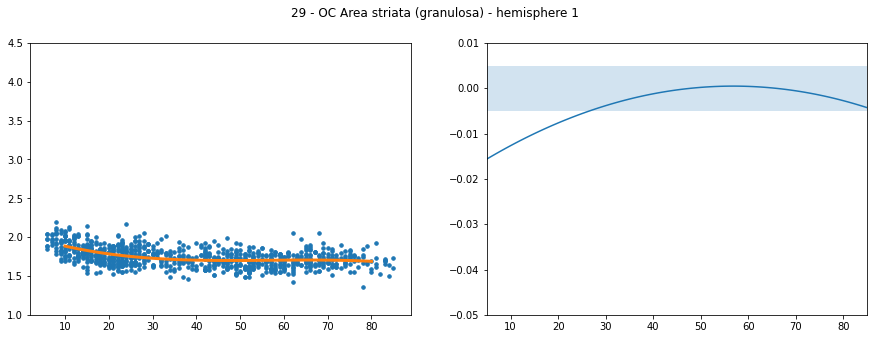

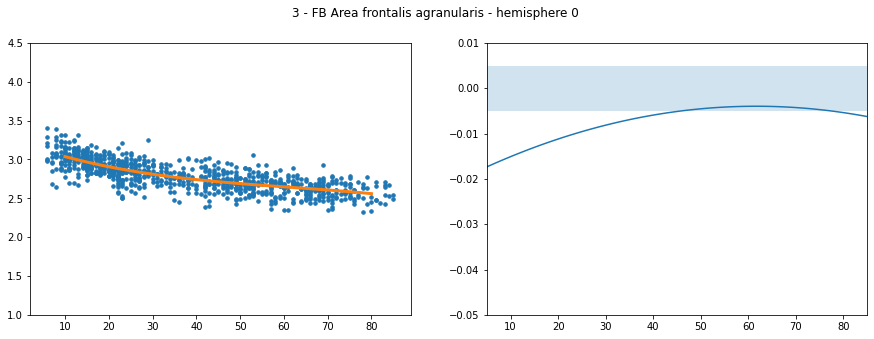

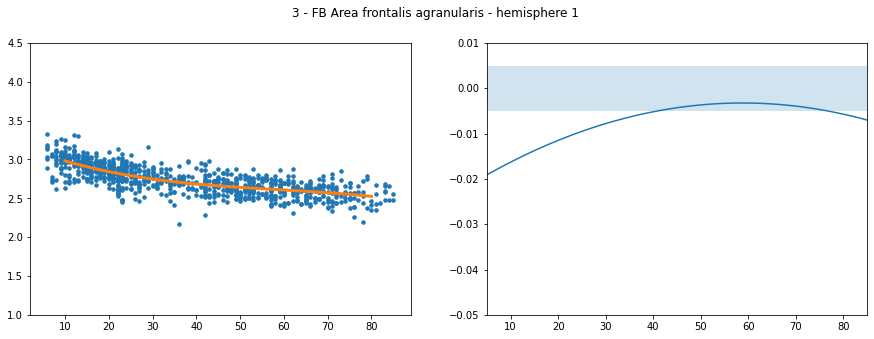

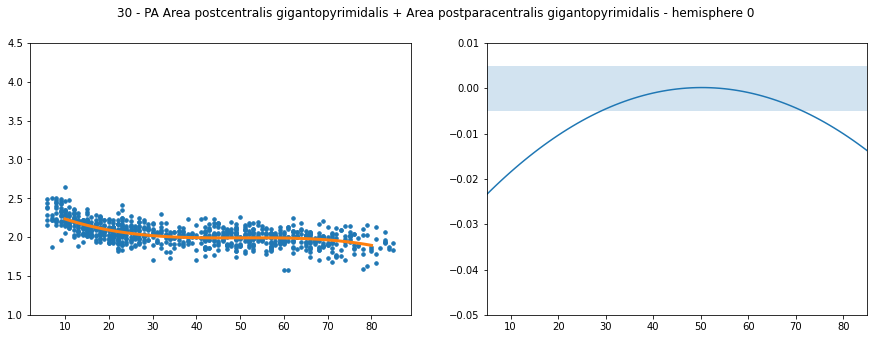

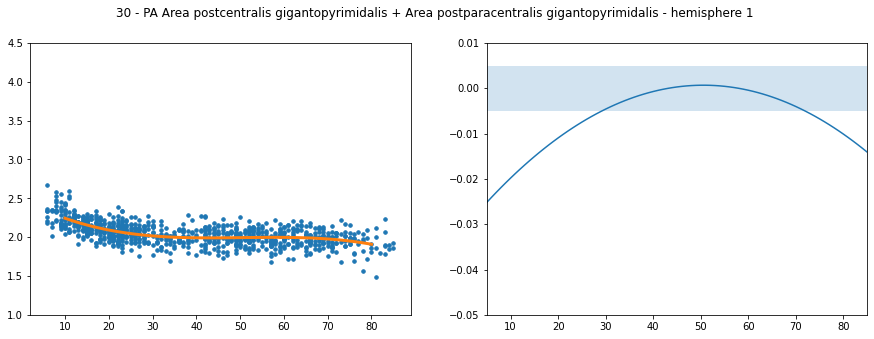

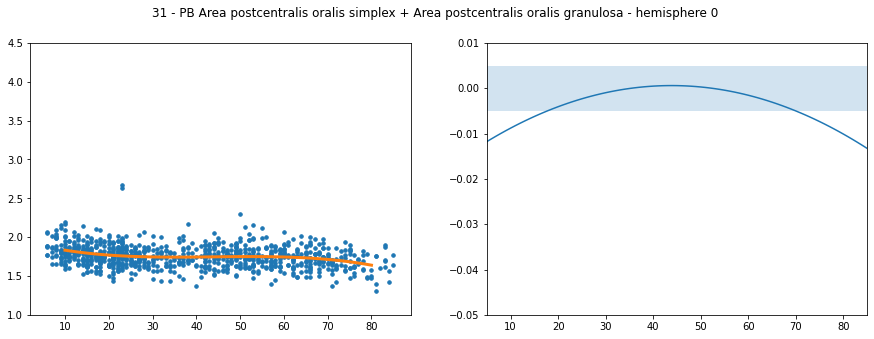

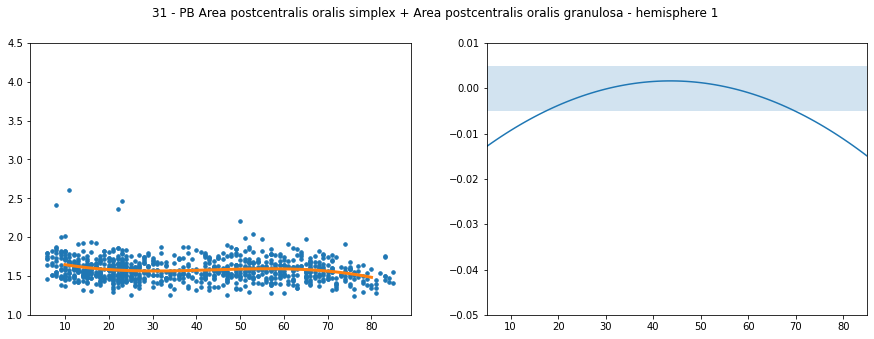

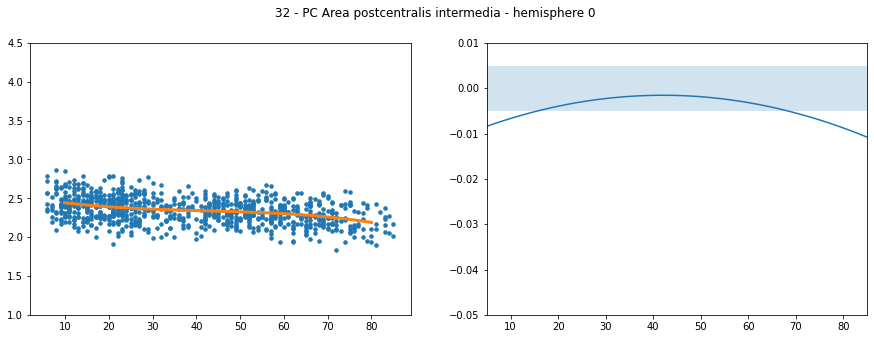

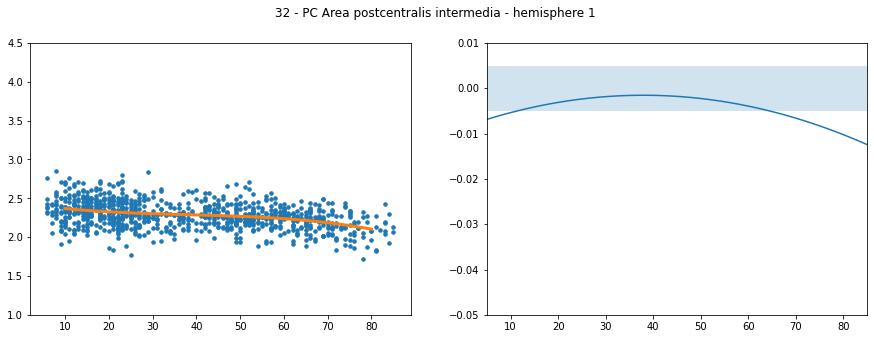

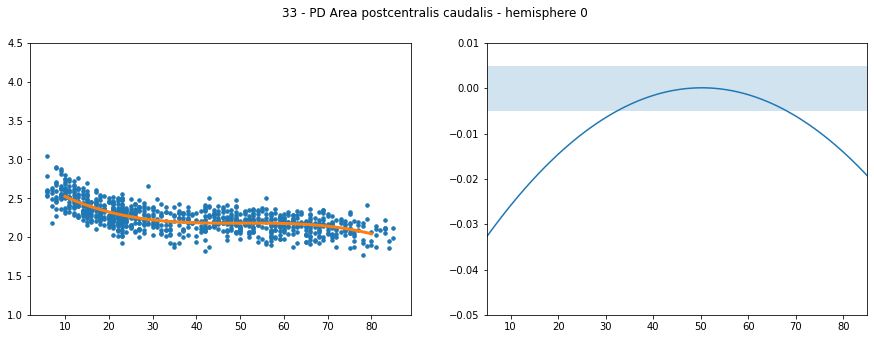

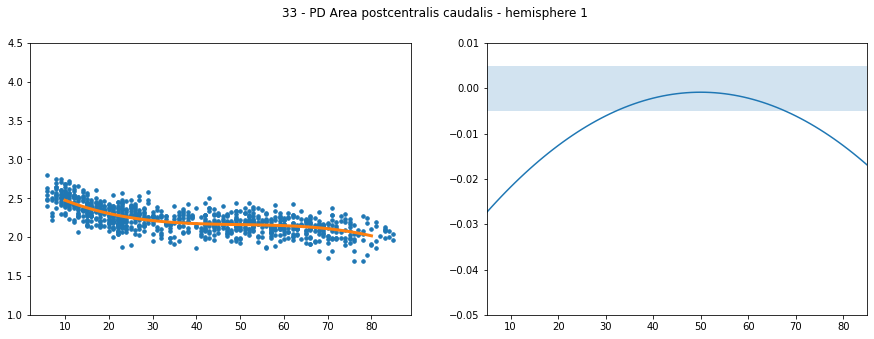

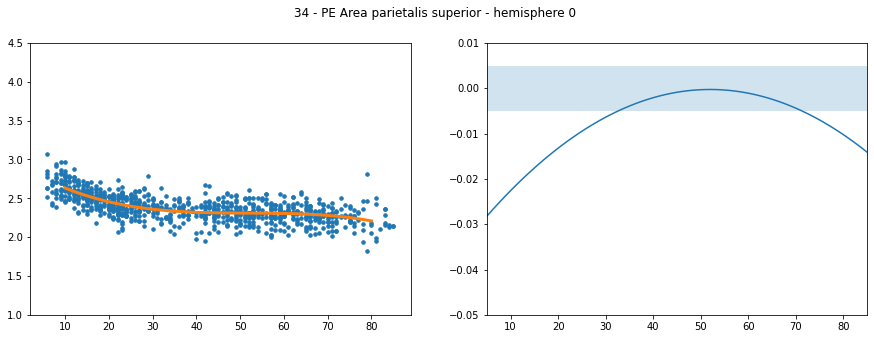

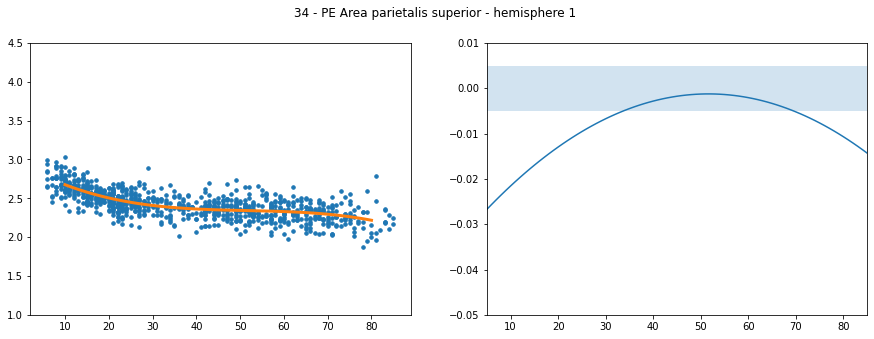

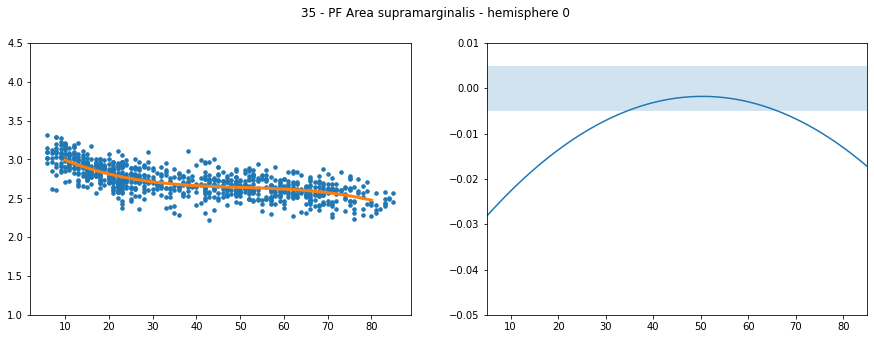

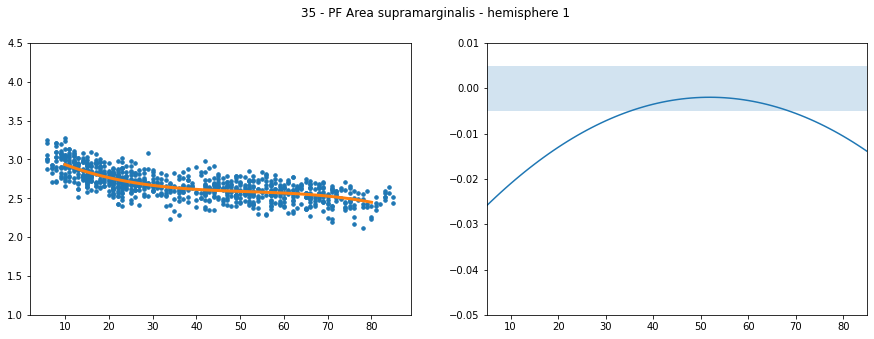

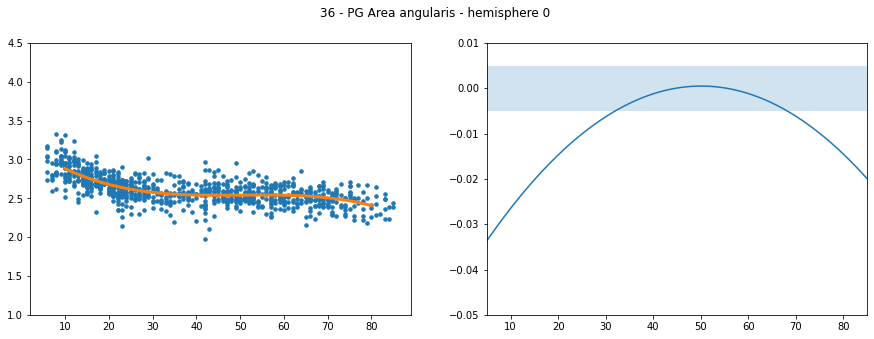

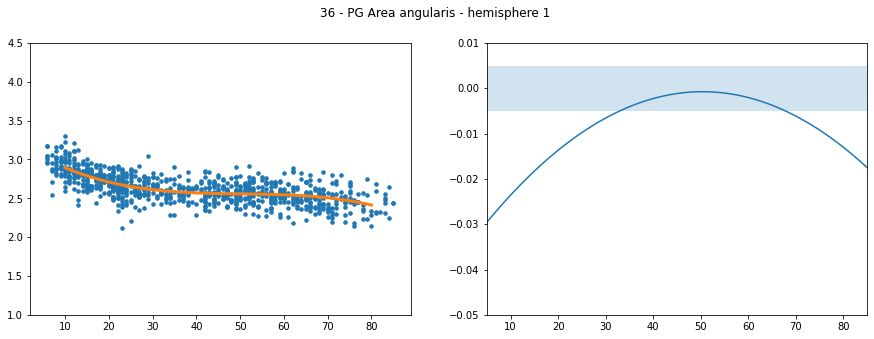

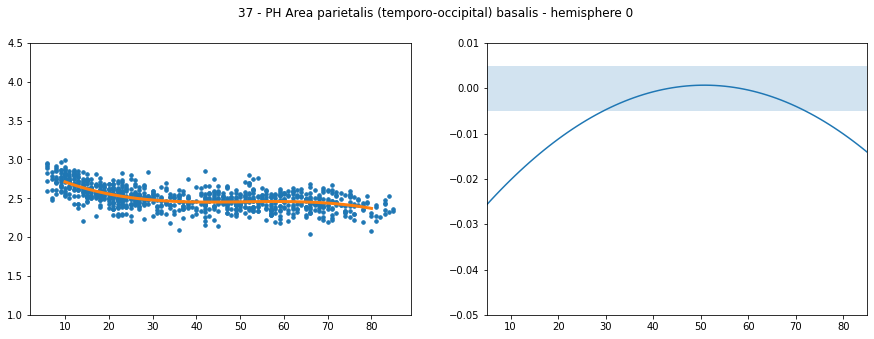

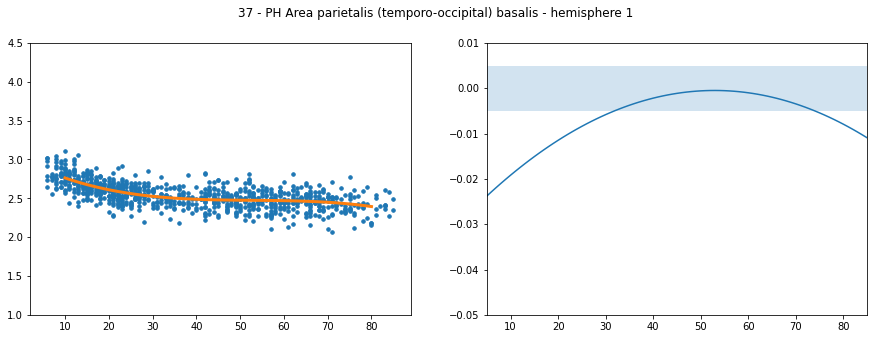

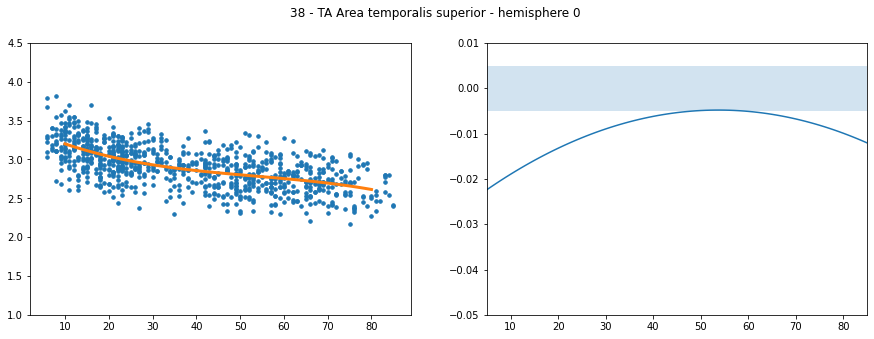

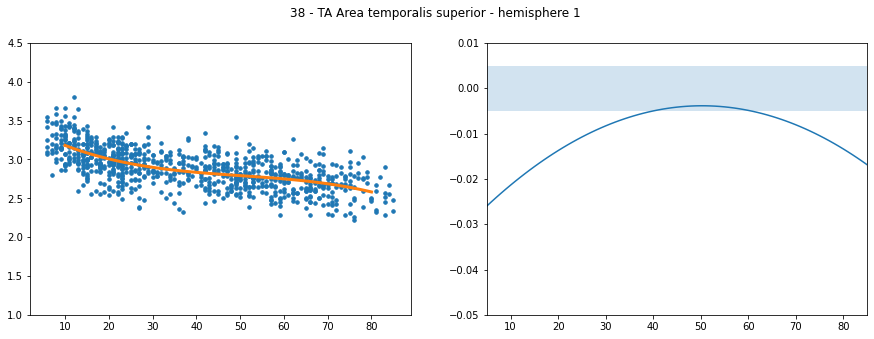

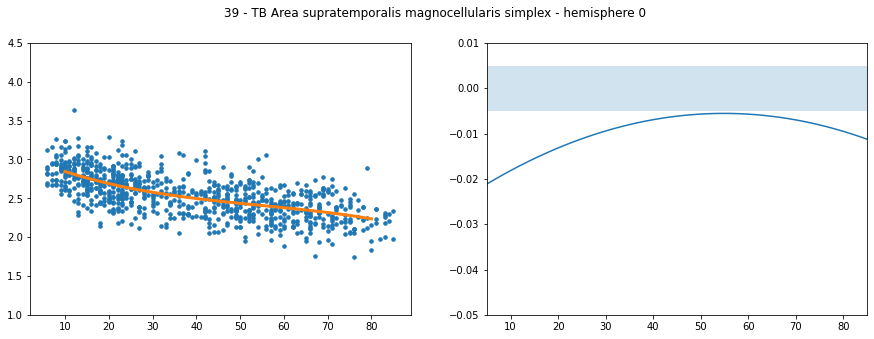

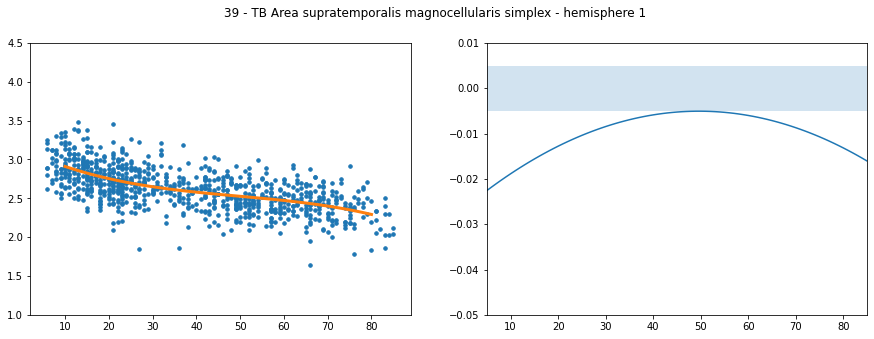

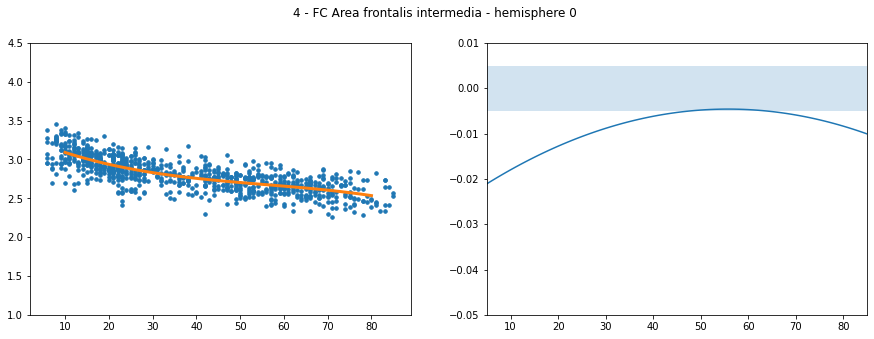

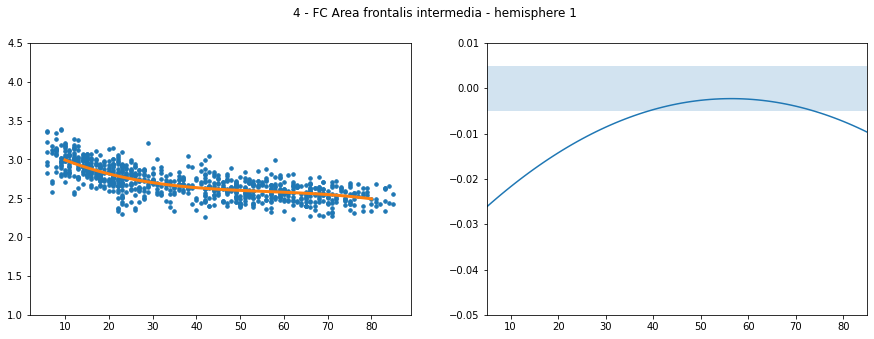

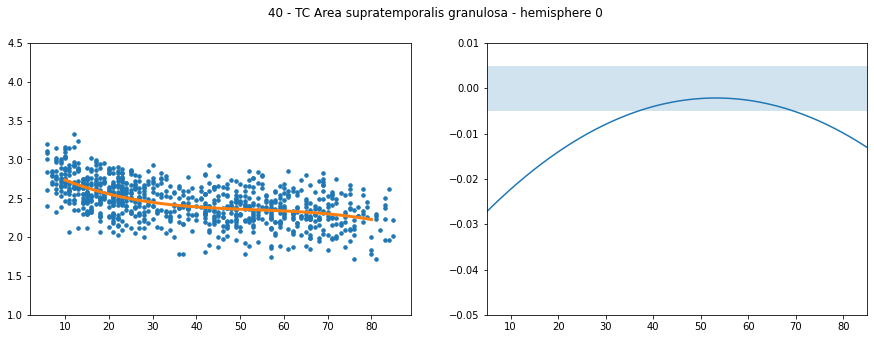

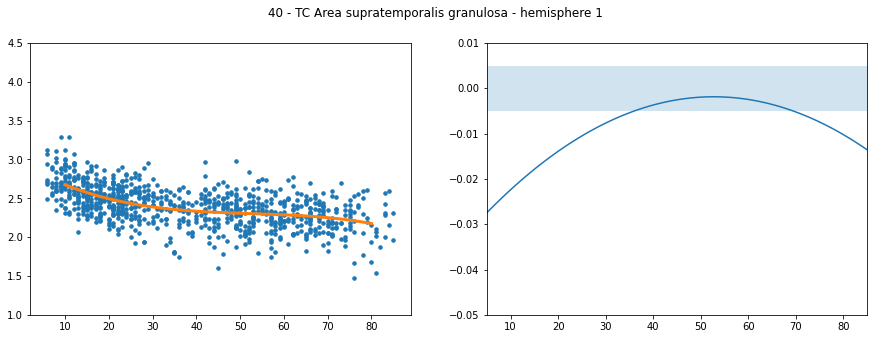

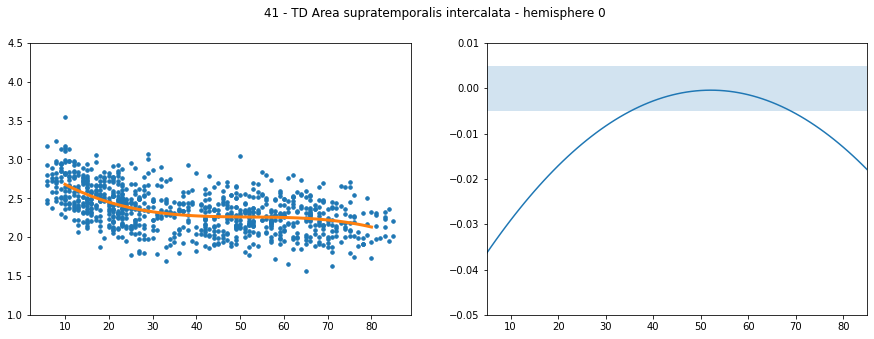

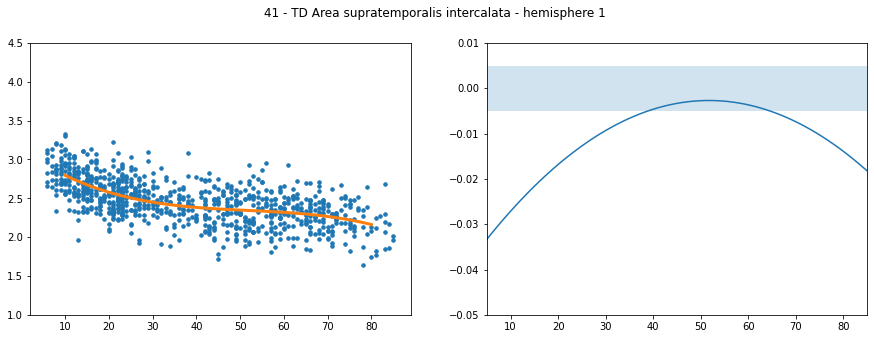

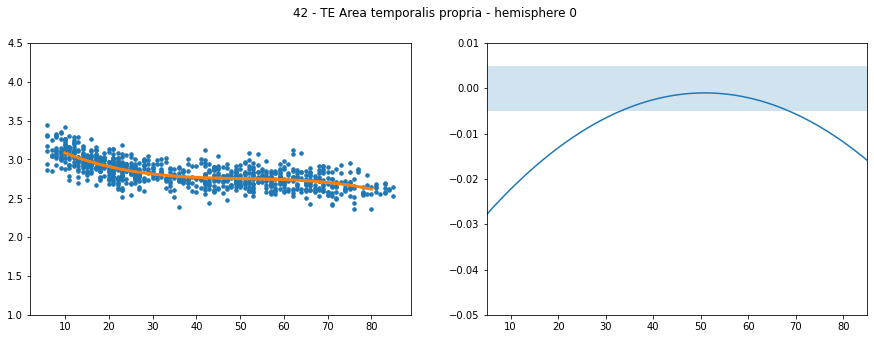

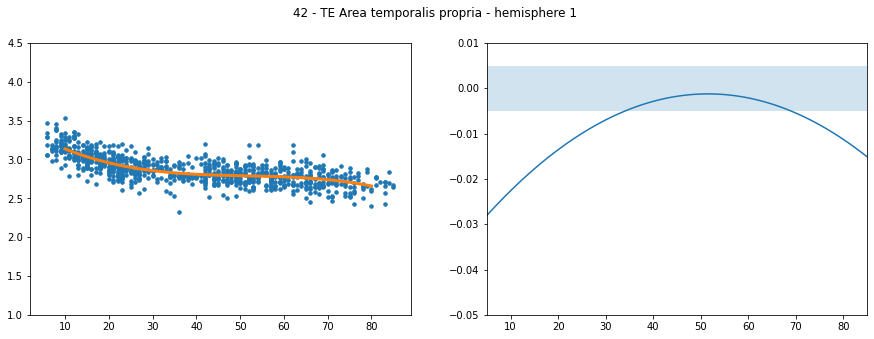

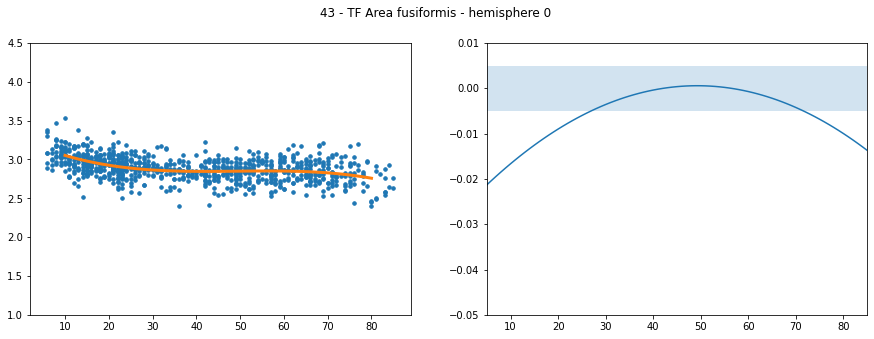

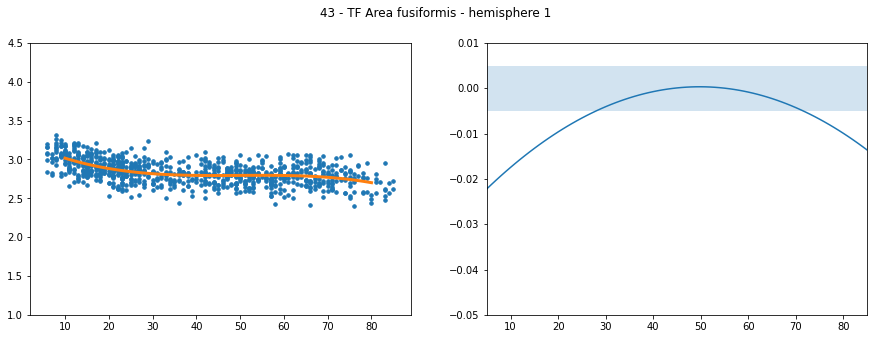

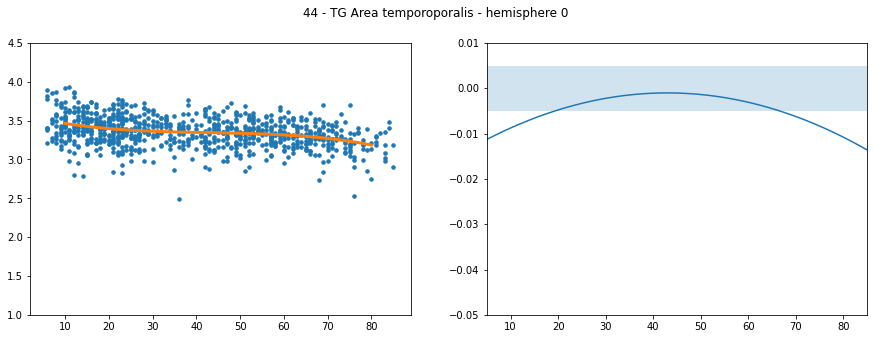

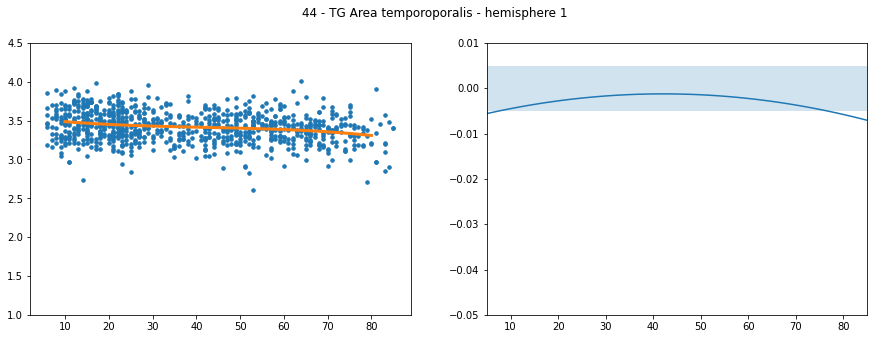

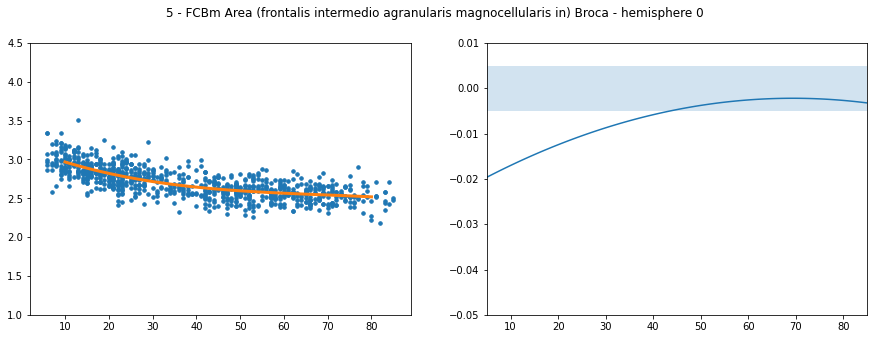

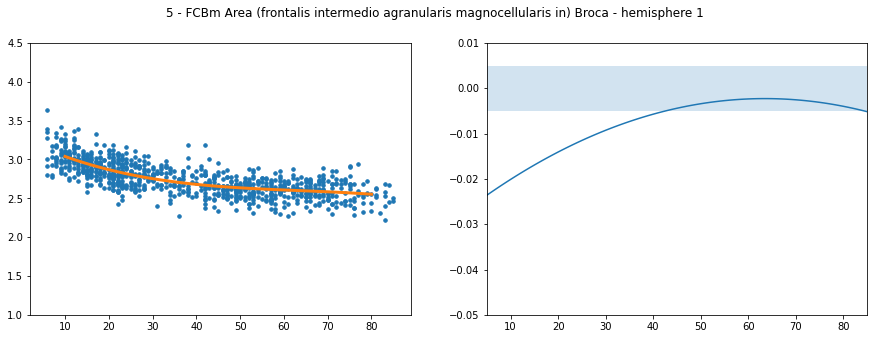

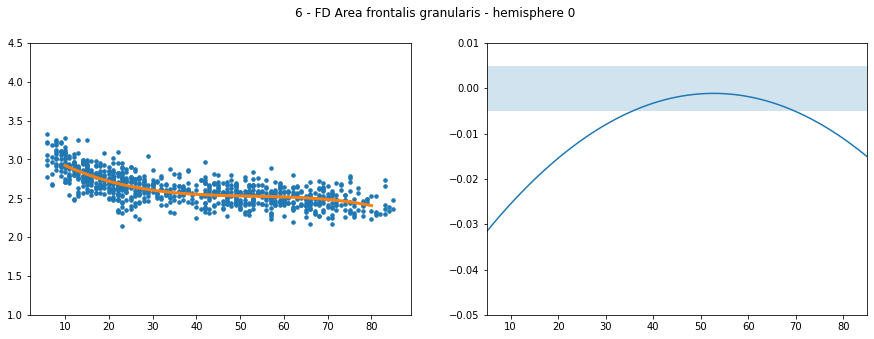

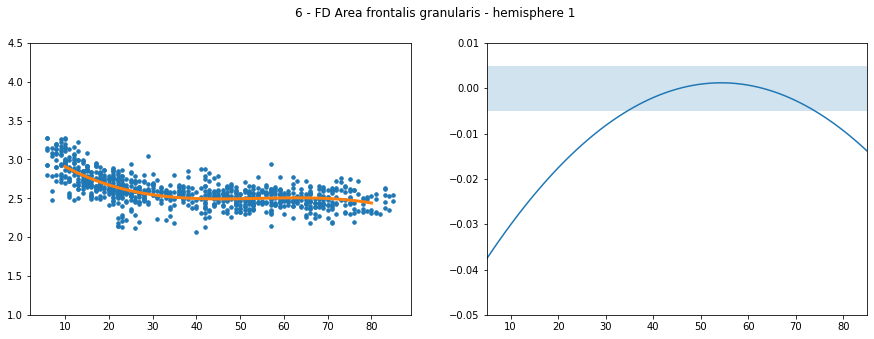

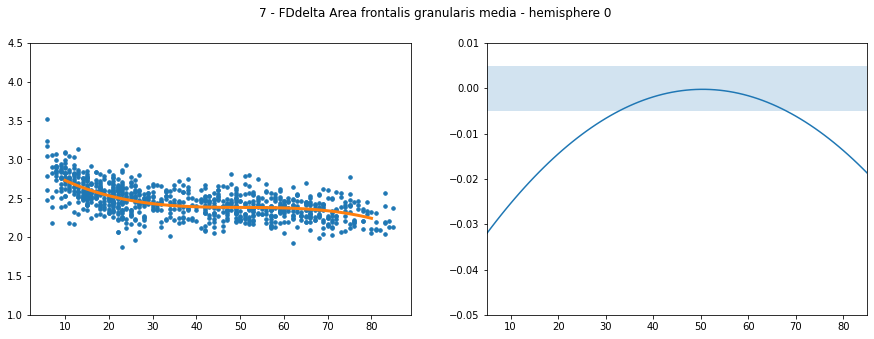

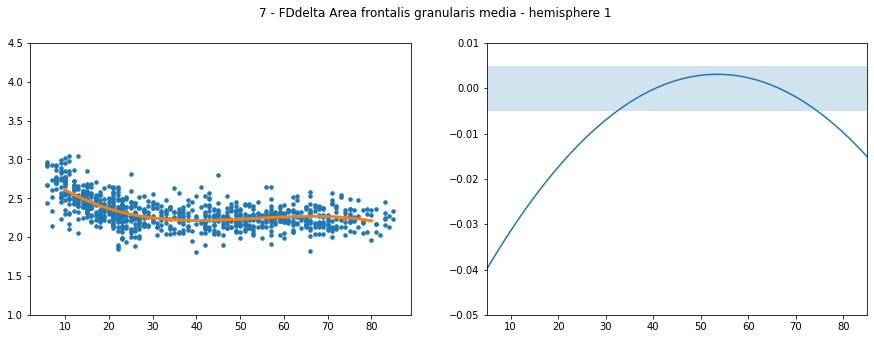

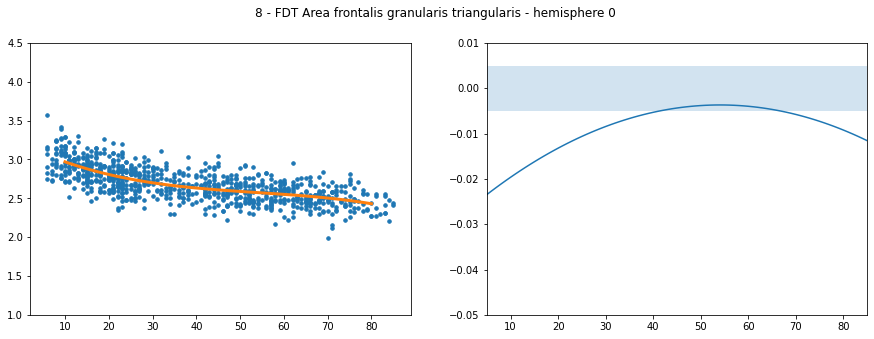

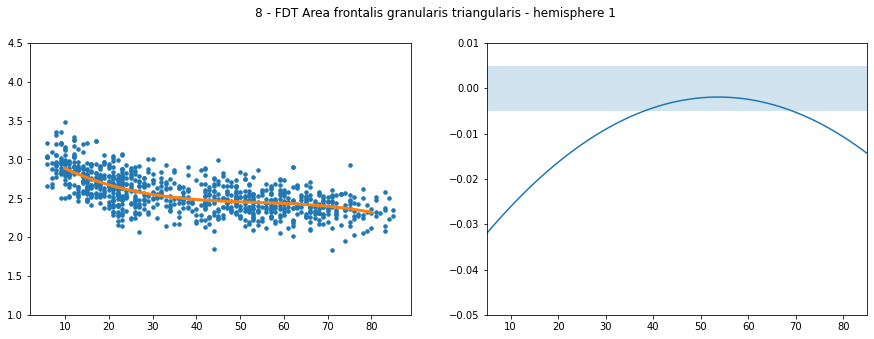

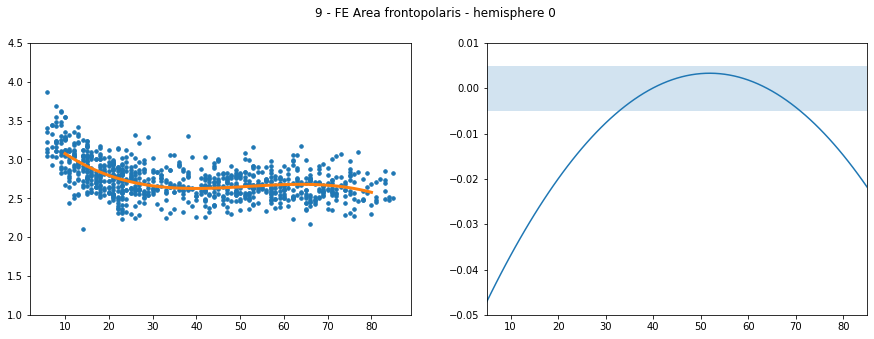

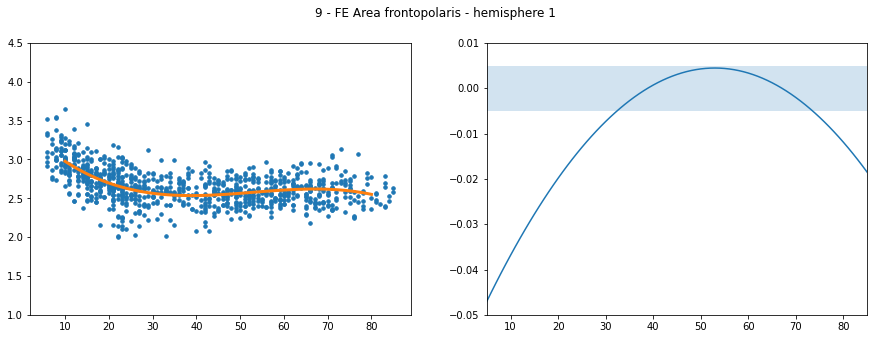

In [7]:
# ordenacao
A = np.sort(pd.Series([a[1:] for a in df.h_structure.unique()]).unique())
B = []
for a in A:
    B.append('0'+ a)
    B.append('1'+ a) 

taxa_anual =[]
for h_structure in tqdm(B):
    
    # variacao da espessura
    age = df[df.h_structure == h_structure].age
    thickness = df[df.h_structure == h_structure].thickness
    z = np.polyfit(age, thickness, 3)
    p = np.poly1d(z)
    xp = np.linspace(10, 80, 100)
    
    # variacao da variacao da espessura
    p2 = np.polyder(p)
    derivada = []
    for year in range(0, 100):
        derivada.append(p2(year))
    taxa_anual.append([h_structure]+ derivada)
    
    # plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    a = h_structure[1:]
    b = ' - '+df[df.h_structure == h_structure].name.iloc[0] 
    c = ' - hemisphere '+ str(df[df.h_structure == h_structure].hemisphere.iloc[0])
    fig.suptitle(a+b+c)
    _ = ax1.plot(age, thickness, '.', xp, p(xp), '-', linewidth=3, markersize=7)
    ax1.axis(ymin=1,ymax=4.5)
    ax2.plot(derivada)
    ax2.axis(ymin=-0.05,ymax=0.01)
    ax2.axis(xmin=5,xmax=85)
    ax2.fill_between([5,85], 0.005, -0.005, alpha=.2)
    
taxa_anual = pd.DataFrame(taxa_anual)
taxa_anual = taxa_anual.rename(columns={0: "atlasEcono"})
taxa_anual.set_index('atlasEcono', inplace=True)

In [8]:
taxa_anual

1         2         3         4         5         6    \
atlasEcono                                                               
010        -0.034602 -0.033335 -0.032092 -0.030873 -0.029677 -0.028505   
110        -0.041652 -0.040099 -0.038575 -0.037080 -0.035613 -0.034176   
011        -0.035244 -0.033992 -0.032762 -0.031553 -0.030366 -0.029201   
111        -0.036694 -0.035406 -0.034139 -0.032895 -0.031673 -0.030474   
012        -0.033226 -0.032147 -0.031086 -0.030042 -0.029015 -0.028007   
...              ...       ...       ...       ...       ...       ...   
17         -0.049258 -0.047318 -0.045415 -0.043548 -0.041718 -0.039925   
08         -0.027719 -0.026837 -0.025972 -0.025124 -0.024292 -0.023476   
18         -0.038517 -0.037166 -0.035841 -0.034542 -0.033267 -0.032019   
09         -0.058453 -0.056094 -0.053782 -0.051515 -0.049294 -0.047119   
19         -0.058362 -0.056011 -0.053705 -0.051444 -0.049228 -0.047056   

                 7         8         9         10   ...       91        92   \
atlasEcono                                          ...                       
010        -0.027356 -0.026231 -0.025130 -0.024052  ... -0.015198 -0.016057   
110        -0.032767 -0.031387 -0.030036 -0.028713  ... -0.017288 -0.018328   
011        -0.028057 -0.026934 -0.025833 -0.024754  ... -0.008843 -0.009529   
111        -0.029297 -0.028141 -0.027009 -0.025898  ... -0.009802 -0.010515   
012        -0.027015 -0.026041 -0.025085 -0.024146  ... -0.006160 -0.006655   
...              ...       ...       ...       ...  ...       ...       ...   
17         -0.038168 -0.036448 -0.034765 -0.033118  ... -0.021349 -0.022706   
08         -0.022677 -0.021894 -0.021128 -0.020378  ... -0.014317 -0.014917   
18         -0.030795 -0.029597 -0.028425 -0.027277  ... -0.018678 -0.019613   
09         -0.044990 -0.042907 -0.040870 -0.038879  ... -0.030013 -0.031786   
19         -0.044929 -0.042848 -0.040810 -0.038818  ... -0.026275 -0.027958   

                 93        94        95        96        97        98   \
atlasEcono                                                               
010        -0.016940 -0.017846 -0.018776 -0.019730 -0.020707 -0.021708   
110        -0.019397 -0.020495 -0.021622 -0.022778 -0.023962 -0.025175   
011        -0.010237 -0.010967 -0.011718 -0.012491 -0.013285 -0.014101   
111        -0.011251 -0.012008 -0.012788 -0.013590 -0.014415 -0.015262   
012        -0.007167 -0.007697 -0.008244 -0.008809 -0.009391 -0.009991   
...              ...       ...       ...       ...       ...       ...   
17         -0.024099 -0.025528 -0.026994 -0.028497 -0.030036 -0.031612   
08         -0.015534 -0.016167 -0.016816 -0.017482 -0.018165 -0.018864   
18         -0.020573 -0.021559 -0.022570 -0.023606 -0.024668 -0.025756   
09         -0.033604 -0.035468 -0.037378 -0.039334 -0.041336 -0.043384   
19         -0.029685 -0.031457 -0.033274 -0.035136 -0.037043 -0.038995   

                 99        100  
atlasEcono                      
010        -0.022732 -0.023780  
110        -0.026417 -0.027688  
011        -0.014938 -0.015797  
111        -0.016130 -0.017022  
012        -0.010608 -0.011243  
...              ...       ...  
17         -0.033225 -0.034874  
08         -0.019579 -0.020311  
18         -0.026868 -0.028006  
09         -0.045478 -0.047617  
19         -0.040991 -0.043032  

[76 rows x 100 columns]

-------------------

## 2. Modelagem para prever variação de espessura anual

#### 2.1. DataSet

In [9]:
def rate(h_structure, age):
    return taxa_anual.loc[h_structure, age]

# add anual rate
df1 = df.copy()
df1['anual_rate'] = df1.apply(lambda x: rate(x.h_structure, x.age), axis=1)

# add initial thickness (at 10 years)
thickness10 = df1[df1.age == 10][['h_structure', 'thickness']].groupby(['h_structure']).mean()
thickness10 = thickness10.rename(columns={'thickness':'thickness10'})
df1 = df1.merge(thickness10, on='h_structure')

# uni os dados de cada idade
dfs = []
for h_structure in df.h_structure.unique():
    df0 = df1[df1.h_structure == h_structure].groupby(['age']).mean()
    df0['h_structure'] = h_structure
    dfs.append(df0.reset_index())

# show
df1 = pd.concat(dfs).reset_index(drop=True)
df1

age  hemisphere  atlasEcono      area      curv      sulc  thickness  \
0       6         0.0        10.0  0.679858 -0.057141 -0.332572   3.123001   
1       7         0.0        10.0  0.679828 -0.060188 -0.378362   2.968792   
2       8         0.0        10.0  0.675299 -0.059163 -0.183841   3.086555   
3       9         0.0        10.0  0.684568 -0.055530 -0.199519   3.017535   
4      10         0.0        10.0  0.682791 -0.053920 -0.180964   3.062818   
...   ...         ...         ...       ...       ...       ...        ...   
6074   81         1.0         9.0  0.676160 -0.079631 -3.179284   2.514800   
6075   82         1.0         9.0  0.697372 -0.045088 -3.307452   2.428034   
6076   83         1.0         9.0  0.667191 -0.091600 -3.111183   2.582450   
6077   84         1.0         9.0  0.651973 -0.080314 -2.993992   2.494349   
6078   85         1.0         9.0  0.705072 -0.074632 -3.213442   2.603051   

           sex  handedness  macro_area  ...  bblayer6_age   ve1_age   ve2_age  \
0     0.714286    1.857143         1.0  ...      1.465116  0.612245  0.204082   
1     0.000000    1.666667         1.0  ...      1.709302  0.714286  0.238095   
2     0.333333    1.666667         1.0  ...      1.953488  0.816327  0.272109   
3     0.357143    1.642857         1.0  ...      2.197674  0.918367  0.306122   
4     0.500000    1.833333         1.0  ...      2.441860  1.020408  0.340136   
...        ...         ...         ...  ...           ...       ...       ...   
6074  0.500000    2.000000         1.0  ...     19.078512  7.518988  5.126582   
6075  1.000000    2.000000         1.0  ...     19.314049  7.611814  5.189874   
6076  0.200000    2.000000         1.0  ...     19.549587  7.704642  5.253165   
6077  1.000000    1.500000         1.0  ...     19.785124  7.797469  5.316456   
6078  0.000000    2.000000         1.0  ...     20.020660  7.890296  5.379747   

        ve3_age    ve4_age    ve5_age    ve6_age  anual_rate  thickness10  \
0      2.040816   0.102041   1.265306   1.775510   -0.028505     3.062818   
1      2.380952   0.119048   1.476190   2.071429   -0.027356     3.062818   
2      2.721088   0.136054   1.687075   2.367347   -0.026231     3.062818   
3      3.061224   0.153061   1.897959   2.663265   -0.025130     3.062818   
4      3.401361   0.170068   2.108844   2.959184   -0.024052     3.062818   
...         ...        ...        ...        ...         ...          ...   
6074  20.506329  10.253164  13.670887  23.924051   -0.011914     3.032003   
6075  20.759495  10.379747  13.839663  24.219410   -0.013149     3.032003   
6076  21.012659  10.506330  14.008439  24.514769   -0.014428     3.032003   
6077  21.265823  10.632912  14.177216  24.810127   -0.015752     3.032003   
6078  21.518988  10.759494  14.345992  25.105486   -0.017121     3.032003   

      h_structure  
0             010  
1             010  
2             010  
3             010  
4             010  
...           ...  
6074           19  
6075           19  
6076           19  
6077           19  
6078           19  

[6079 rows x 43 columns]

In [10]:
df1.columns

Index(['age', 'hemisphere', 'atlasEcono', 'area', 'curv', 'sulc', 'thickness',
       'sex', 'handedness', 'macro_area', 've_1', 've_2', 've_3', 've_4',
       've_5', 've_6', 'bigbrain_layer_1', 'bigbrain_layer_2',
       'bigbrain_layer_3', 'bigbrain_layer_4', 'bigbrain_layer_5',
       'bigbrain_layer_6', 'bigbrain_layer_1_r', 'bigbrain_layer_2_r',
       'bigbrain_layer_3_r', 'bigbrain_layer_4_r', 'bigbrain_layer_5_r',
       'bigbrain_layer_6_r', 'bblayer1_age', 'bblayer2_age', 'bblayer3_age',
       'bblayer4_age', 'bblayer5_age', 'bblayer6_age', 've1_age', 've2_age',
       've3_age', 've4_age', 've5_age', 've6_age', 'anual_rate', 'thickness10',
       'h_structure'],
      dtype='object')

In [11]:
df1['thickness_layer_1'] = df1.thickness * df1.bigbrain_layer_1
df1['thickness_layer_2'] = df1.thickness * df1.bigbrain_layer_2
df1['thickness_layer_3'] = df1.thickness * df1.bigbrain_layer_3
df1['thickness_layer_4'] = df1.thickness * df1.bigbrain_layer_4
df1['thickness_layer_5'] = df1.thickness * df1.bigbrain_layer_5
df1['thickness_layer_6'] = df1.thickness * df1.bigbrain_layer_6
df1['sum_thickness_layers'] = df1['thickness_layer_1']+ df1['thickness_layer_2']+df1['thickness_layer_3']+df1['thickness_layer_4']+df1['thickness_layer_5']+df1['thickness_layer_6']
df1[['sum_thickness_layers', 'thickness']]

sum_thickness_layers  thickness
0                 3.123001   3.123001
1                 2.968792   2.968792
2                 3.086555   3.086555
3                 3.017535   3.017535
4                 3.062819   3.062818
...                    ...        ...
6074              2.514800   2.514800
6075              2.428034   2.428034
6076              2.582450   2.582450
6077              2.494349   2.494349
6078              2.603051   2.603051

[6079 rows x 2 columns]

#### 2.2 Feature Analyses

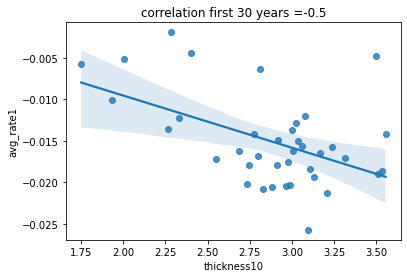

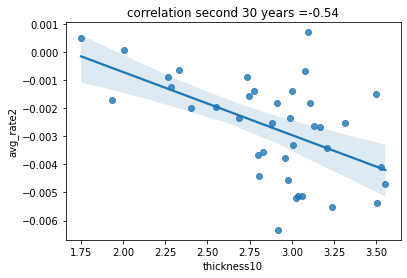

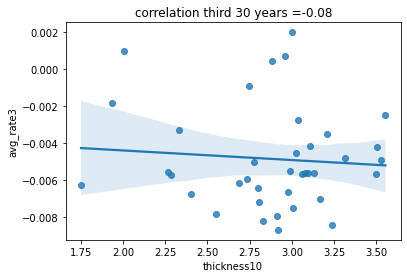

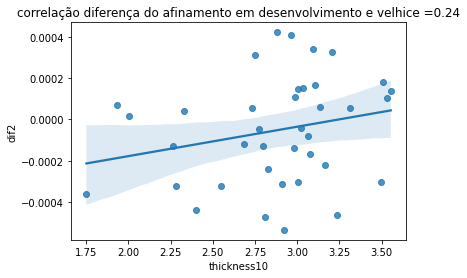

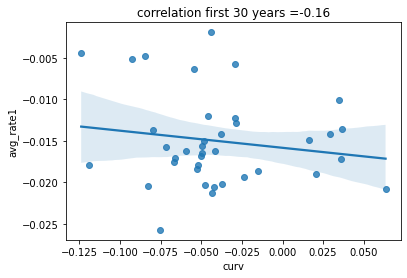

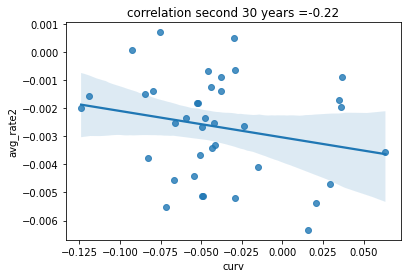

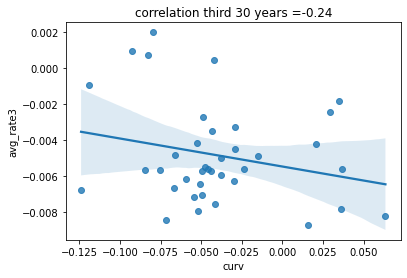

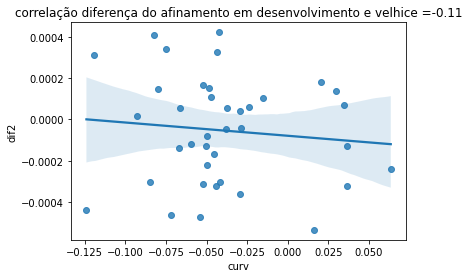

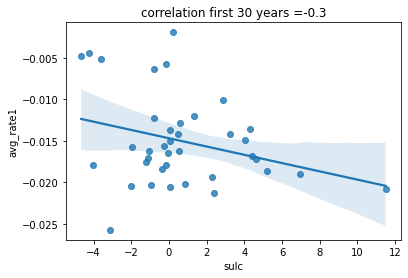

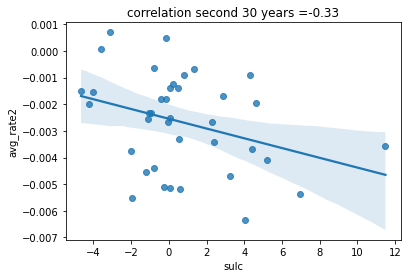

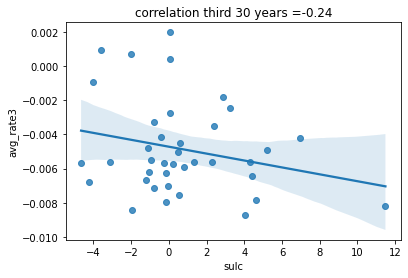

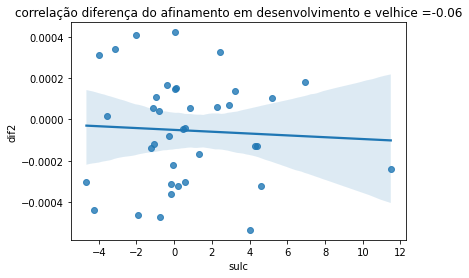

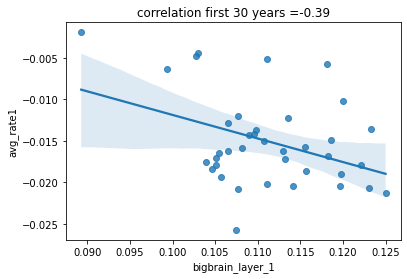

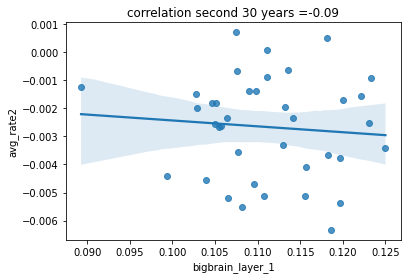

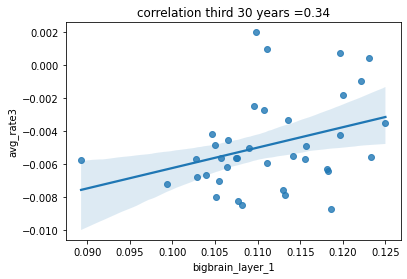

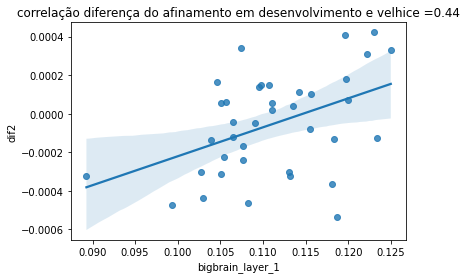

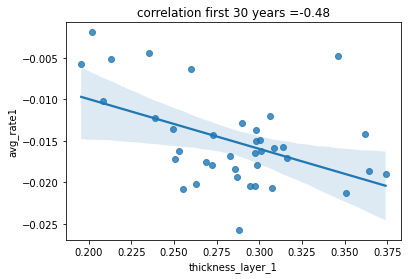

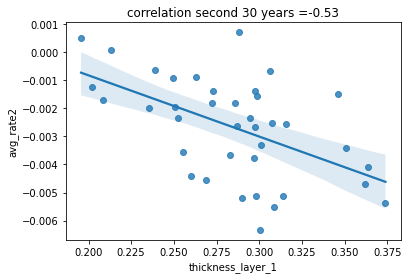

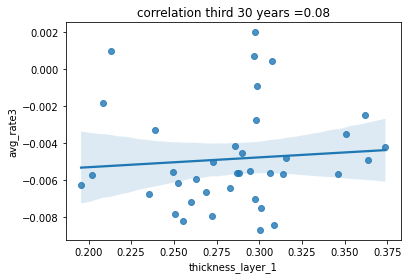

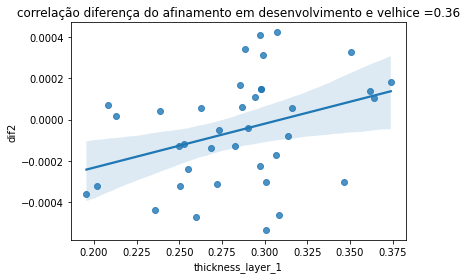

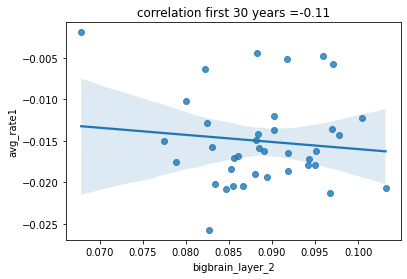

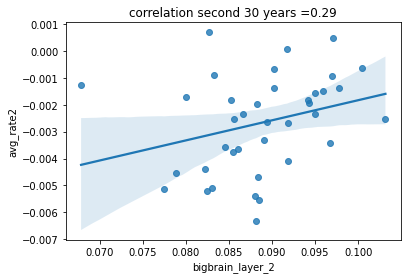

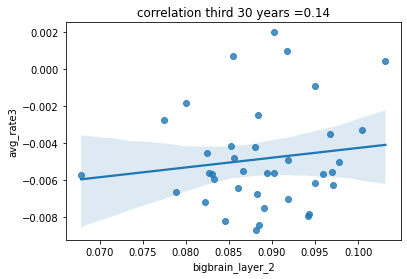

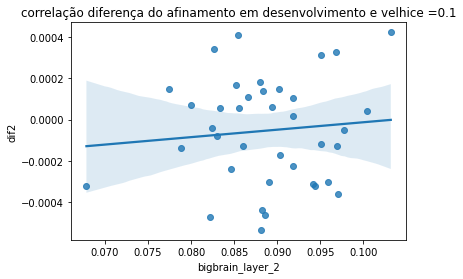

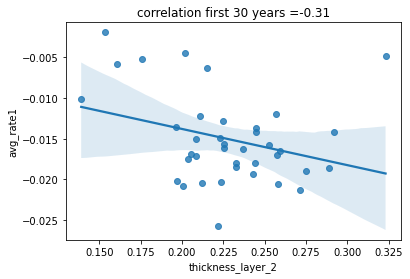

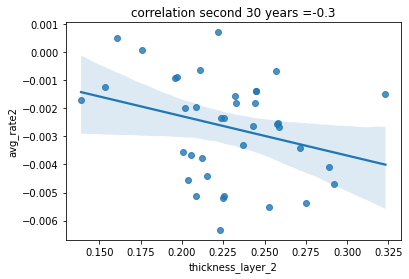

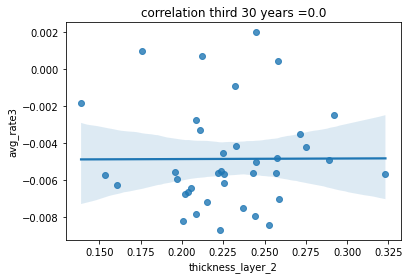

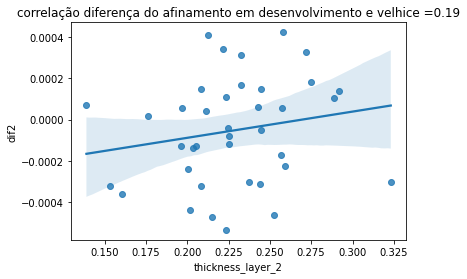

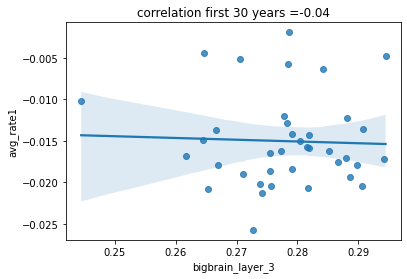

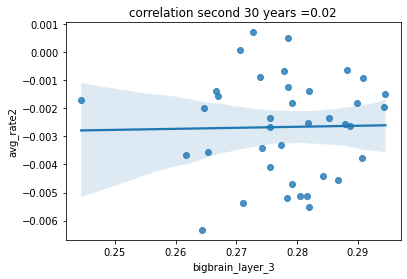

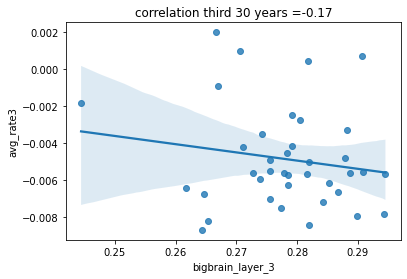

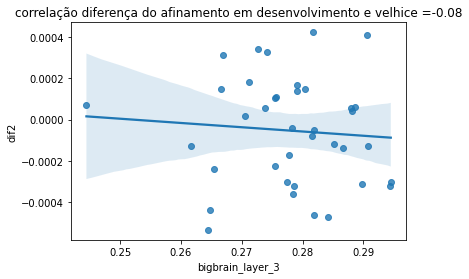

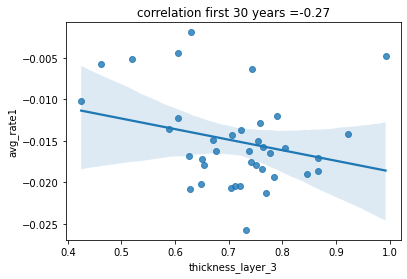

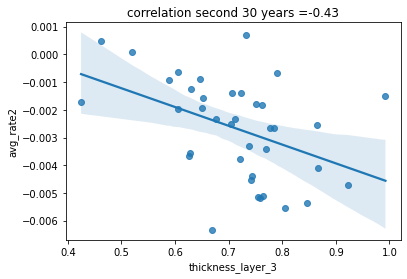

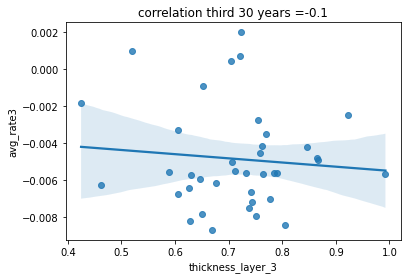

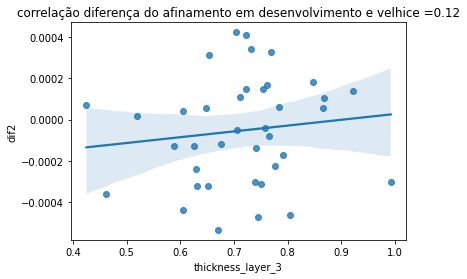

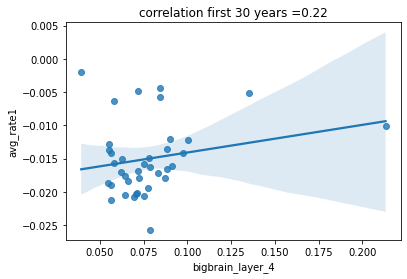

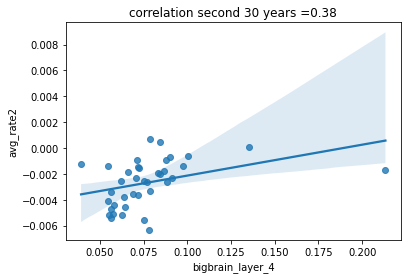

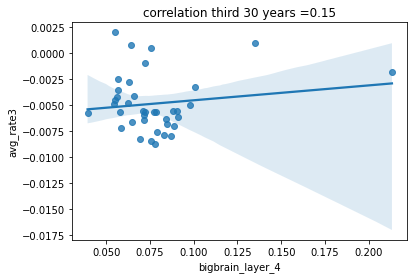

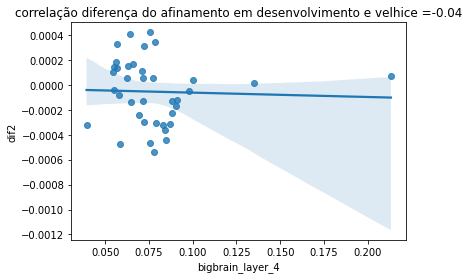

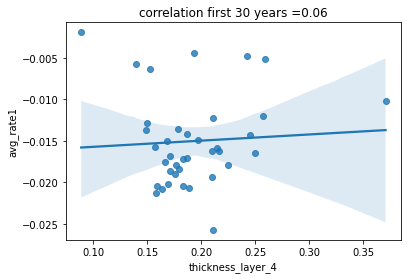

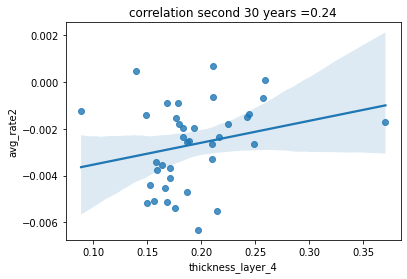

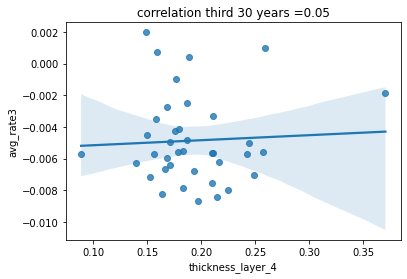

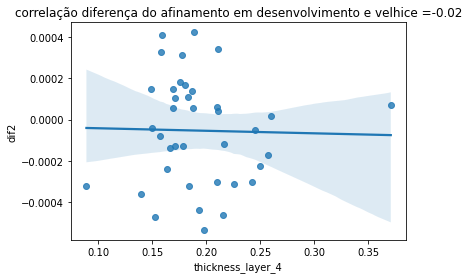

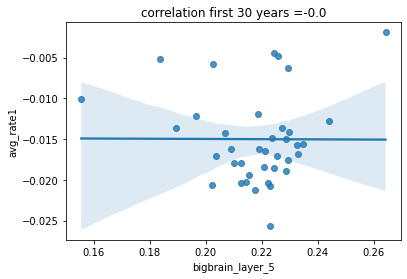

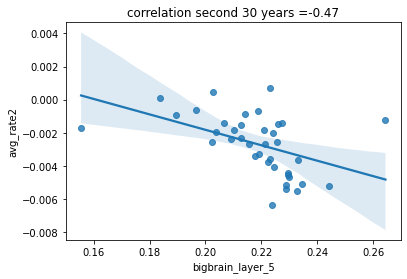

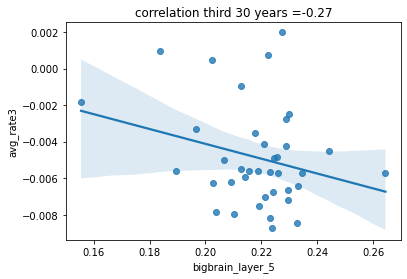

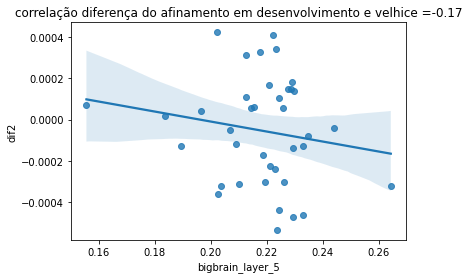

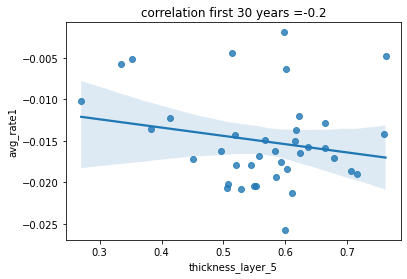

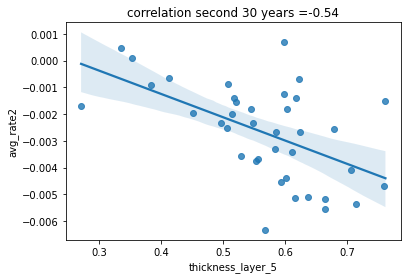

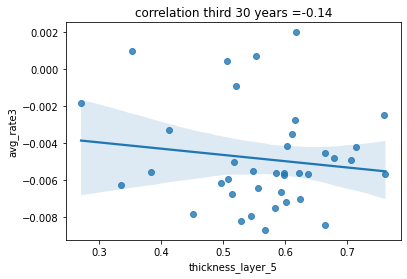

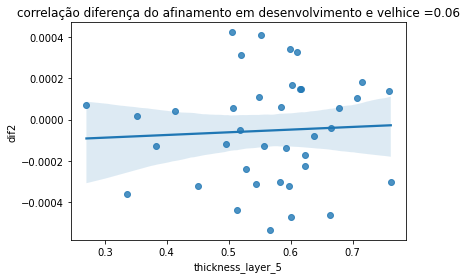

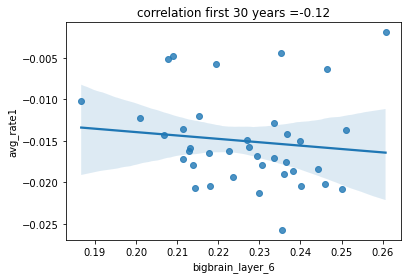

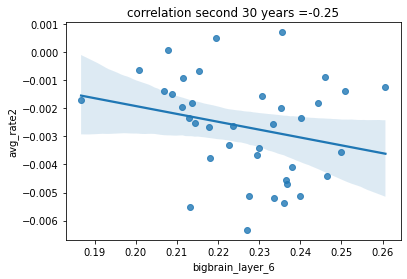

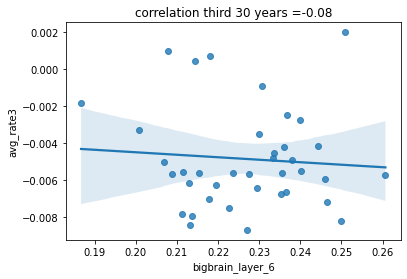

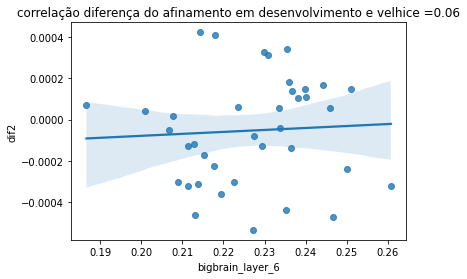

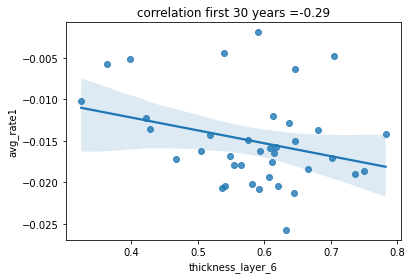

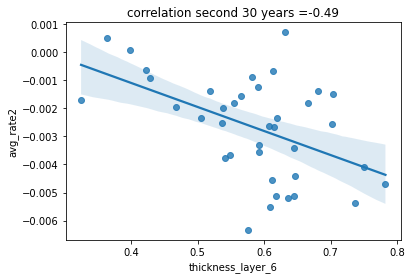

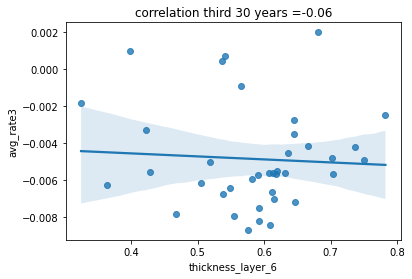

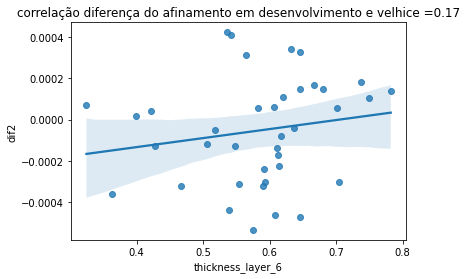

In [12]:
list_avg_rate = []

for i in df1.atlasEcono.unique():
    
    df5 = df1[df1.atlasEcono==i]
    
    avg_rate1 = df5[df1.age<=30].anual_rate.mean()
    avg_rate2 = df5[(df1.age<60) & (df1.age>30)].anual_rate.mean()
    avg_rate3 = df5[df1.age>=60].anual_rate.mean()
    
    t10 = df5.thickness10.mean()
    curv = df5.curv.mean()
    sulc = df5.sulc.mean()
    
    l1 = df5.thickness_layer_1.mean()
    b1 = df5.bigbrain_layer_1.mean()
    l2 = df5.thickness_layer_2.mean()
    b2 = df5.bigbrain_layer_2.mean()
    l3 = df5.thickness_layer_3.mean()
    b3 = df5.bigbrain_layer_3.mean()
    l4 = df5.thickness_layer_4.mean()
    b4 = df5.bigbrain_layer_4.mean()
    l5 = df5.thickness_layer_5.mean()
    b5 = df5.bigbrain_layer_5.mean()
    l6 = df5.thickness_layer_6.mean()
    b6 = df5.bigbrain_layer_6.mean()
    
    list_avg_rate.append([i,
                          avg_rate1,avg_rate2,avg_rate3,
                          t10, curv,sulc,
                          b1,l1,
                          b2,l2,
                          b3,l3,
                          b4,l4,
                          b5,l5,
                          b6,l6
                         ])

df5 = pd.DataFrame(list_avg_rate)#.sort_values(by=2)
df5.columns = ['structure_name',
               'avg_rate1', 'avg_rate2', 'avg_rate3',
               'thickness10', # resultados do trabalho do bruno
               'curv', 'sulc',
               'bigbrain_layer_1', 
               'thickness_layer_1', # resultados sofrem interferencia da espessura inicial
               'bigbrain_layer_2', 
               'thickness_layer_2',
               'bigbrain_layer_3', 
               'thickness_layer_3',
               'bigbrain_layer_4', 
               'thickness_layer_4',
               'bigbrain_layer_5', 
               'thickness_layer_5',
               'bigbrain_layer_6', 
               'thickness_layer_6'
               ]

df5['dif2'] = df5.avg_rate1*df5.avg_rate1 - df5.avg_rate3*df5.avg_rate3*10
        
for test in df5.columns[4:-1]:

    corr = np.corrcoef(df5[test],df5.avg_rate1)[0, 1]
    sns.regplot(x=test,y='avg_rate1', data=df5).set(
        title="correlation first 30 years ="+ str(np.round(corr,2)))
    plt.show()

    corr = np.corrcoef(df5[test],df5.avg_rate2)[0, 1]
    sns.regplot(x=test,y='avg_rate2', data=df5).set(
        title="correlation second 30 years ="+ str(np.round(corr,2)))
    plt.show()

    corr = np.corrcoef(df5[test],df5.avg_rate3)[0, 1]
    sns.regplot(x=test,y='avg_rate3', data=df5).set(
        title="correlation third 30 years ="+ str(np.round(corr,2)))
    plt.show() 
    
    corr = np.corrcoef(df5[test],df5.dif2)[0, 1]
    sns.regplot(x=test,y='dif2', data=df5).set(
    title="correlação diferença do afinamento em desenvolvimento e velhice ="+ str(np.round(corr,2)))
    plt.show()


In [13]:
df5.corr()#method='spearman')

structure_name  avg_rate1  avg_rate2  avg_rate3  \
structure_name           1.000000   0.238644   0.195003  -0.330524   
avg_rate1                0.238644   1.000000   0.211924   0.001901   
avg_rate2                0.195003   0.211924   1.000000   0.199021   
avg_rate3               -0.330524   0.001901   0.199021   1.000000   
thickness10             -0.171925  -0.498124  -0.540574  -0.082342   
curv                     0.135533  -0.161224  -0.223904  -0.244102   
sulc                     0.181926  -0.297376  -0.332342  -0.241627   
bigbrain_layer_1        -0.024252  -0.394825  -0.088599   0.344612   
thickness_layer_1       -0.163907  -0.476737  -0.526633   0.084579   
bigbrain_layer_2         0.362335  -0.110540   0.294102   0.136289   
thickness_layer_2        0.052899  -0.308611  -0.296284   0.004225   
bigbrain_layer_3        -0.038161  -0.039629   0.020930  -0.167556   
thickness_layer_3       -0.133394  -0.267159  -0.433413  -0.095021   
bigbrain_layer_4         0.338870   0.216102   0.378288   0.148921   
thickness_layer_4        0.425917   0.063184   0.242533   0.054112   
bigbrain_layer_5        -0.206647  -0.004229  -0.468824  -0.269103   
thickness_layer_5       -0.185604  -0.202329  -0.537206  -0.137415   
bigbrain_layer_6        -0.497044  -0.118485  -0.247057  -0.078254   
thickness_layer_6       -0.323356  -0.292093  -0.490470  -0.061444   
dif2                    -0.514217  -0.549684   0.118098   0.754223   

                   thickness10      curv      sulc  bigbrain_layer_1  \
structure_name       -0.171925  0.135533  0.181926         -0.024252   
avg_rate1            -0.498124 -0.161224 -0.297376         -0.394825   
avg_rate2            -0.540574 -0.223904 -0.332342         -0.088599   
avg_rate3            -0.082342 -0.244102 -0.241627          0.344612   
thickness10           1.000000 -0.049504  0.100811         -0.092025   
curv                 -0.049504  1.000000  0.873840          0.260688   
sulc                  0.100811  0.873840  1.000000          0.278616   
bigbrain_layer_1     -0.092025  0.260688  0.278616          1.000000   
thickness_layer_1     0.926741  0.005390  0.144476          0.230220   
bigbrain_layer_2     -0.038144 -0.004205 -0.041711          0.480524   
thickness_layer_2     0.866836 -0.098182 -0.007878          0.023122   
bigbrain_layer_3      0.233363 -0.096650 -0.234331         -0.251681   
thickness_layer_3     0.943959 -0.121614 -0.050643         -0.252516   
bigbrain_layer_4     -0.574619  0.158890 -0.051128          0.223269   
thickness_layer_4    -0.129960  0.065609 -0.111505          0.105231   
bigbrain_layer_5      0.546361 -0.228858 -0.018763         -0.497500   
thickness_layer_5     0.919802 -0.147283  0.005446         -0.331201   
bigbrain_layer_6      0.318852 -0.085147  0.149776         -0.364399   
thickness_layer_6     0.912593 -0.097123  0.080726         -0.287953   
dif2                  0.237816 -0.105885 -0.055697          0.440358   

                   thickness_layer_1  bigbrain_layer_2  thickness_layer_2  \
structure_name             -0.163907          0.362335           0.052899   
avg_rate1                  -0.476737         -0.110540          -0.308611   
avg_rate2                  -0.526633          0.294102          -0.296284   
avg_rate3                   0.084579          0.136289           0.004225   
thickness10                 0.926741         -0.038144           0.866836   
curv                        0.005390         -0.004205          -0.098182   
sulc                        0.144476         -0.041711          -0.007878   
bigbrain_layer_1            0.230220          0.480524           0.023122   
thickness_layer_1           1.000000          0.153110           0.891390   
bigbrain_layer_2            0.153110          1.000000           0.405251   
thickness_layer_2           0.891390          0.405251           1.000000   
bigbrain_layer_3            0.133736          0.258995           0.329455   
thickness_layer_3           0.8580

In [14]:
df5_n = df5.copy()
df5_n['avg_rate1'] = df5['avg_rate1']/(df5['avg_rate1'].mean())
df5_n['avg_rate2'] = df5['avg_rate2']/(df5['avg_rate2'].mean())
df5_n['avg_rate3'] = df5['avg_rate3']/(df5['avg_rate3'].mean())

#df5_n['dif2'] = df5_n.avg_rate1*df5_n.avg_rate1 - df5_n.avg_rate3*df5_n.avg_rate3
df5_n['dif2'] = df5_n.avg_rate1 - df5_n.avg_rate3

x1 = -0.7
x2 = -x1
g1 = df5_n[df5_n.dif2<x1]
g2 = df5_n[(df5_n.dif2>x1) & (df5_n.dif2<x2)]
g3 = df5_n[df5_n.dif2>x2]

print(len(g1), len(g2), len(g3))
print(g1.bigbrain_layer_1.mean(), g2.bigbrain_layer_1.mean(), g3.bigbrain_layer_1.mean())
print(stats.kruskal(g1.bigbrain_layer_1,g2.bigbrain_layer_1,g2.bigbrain_layer_1)[1])

6 28 4
0.10517821 0.11131252 0.11866246
0.21149316942301186


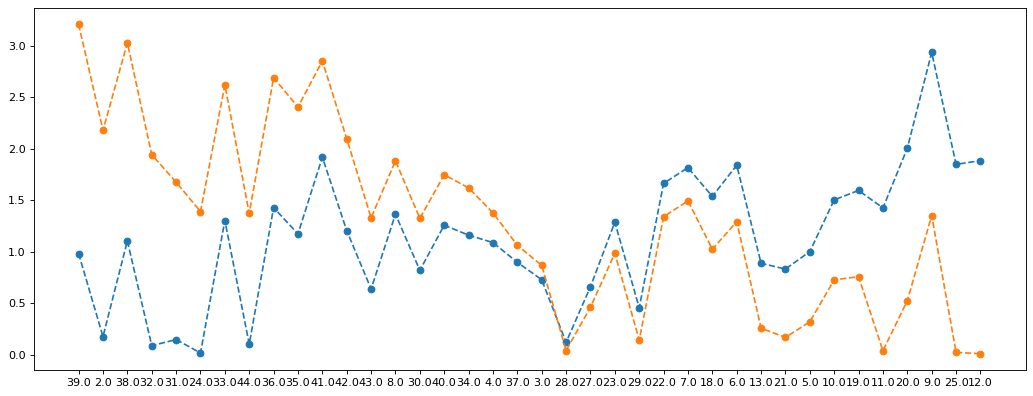

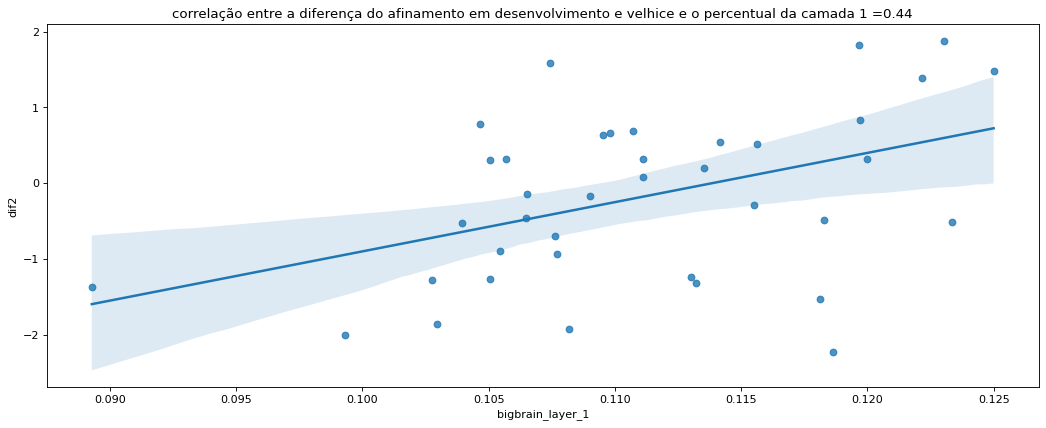

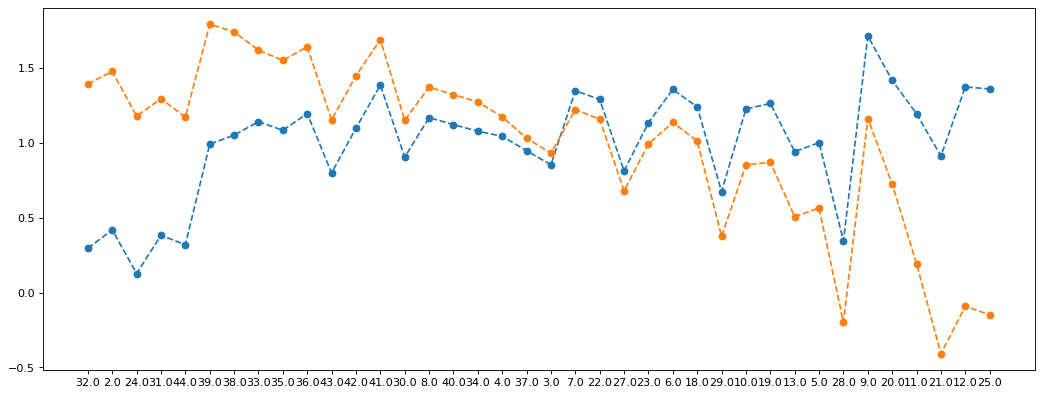

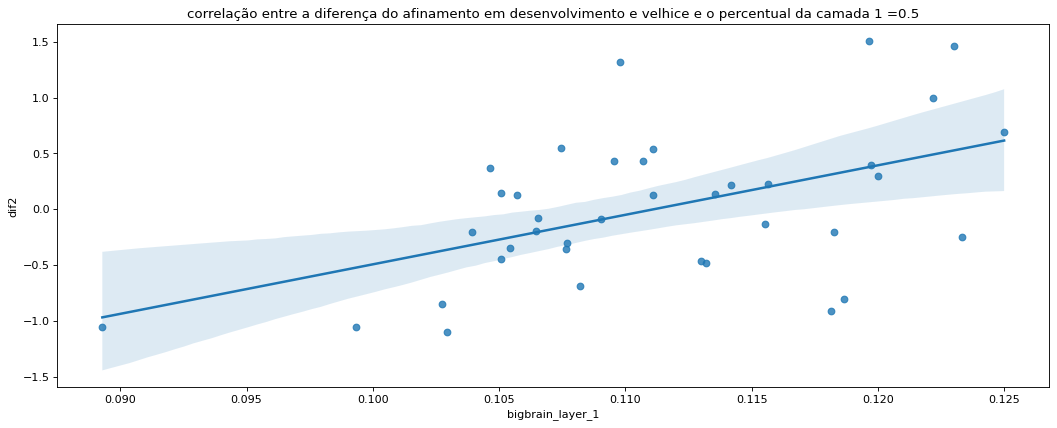

In [15]:
df5_n['dif2'] = df5_n.avg_rate1*df5_n.avg_rate1 - df5_n.avg_rate3*df5_n.avg_rate3
df5_n = df5_n.sort_values(by = 'dif2')
plt.figure(figsize=(16, 6), dpi=80)
plt.plot(df5_n.structure_name.astype(str), df5_n.avg_rate1*df5_n.avg_rate1, '--o') 
plt.plot(df5_n.structure_name.astype(str), df5_n.avg_rate3*df5_n.avg_rate3, '--o')
plt.show()

plt.figure(figsize=(16, 6), dpi=80)
corr = np.corrcoef(df5_n['bigbrain_layer_1'],df5_n.dif2)[0, 1]
sns.regplot(x='bigbrain_layer_1',y='dif2', data=df5_n).set(
    title="correlação entre a diferença do afinamento em desenvolvimento e velhice e o percentual da camada 1 ="+ str(np.round(corr,2)))
plt.show()

df5_n['dif2'] = df5_n.avg_rate1 - df5_n.avg_rate3
df5_n = df5_n.sort_values(by = 'dif2')
plt.figure(figsize=(16, 6), dpi=80)
plt.plot(df5_n.structure_name.astype(str), df5_n.avg_rate1, '--o') 
plt.plot(df5_n.structure_name.astype(str), df5_n.avg_rate3, '--o')
plt.show()

plt.figure(figsize=(16, 6), dpi=80)
corr = np.corrcoef(df5_n['bigbrain_layer_1'],df5_n.dif2)[0, 1]
sns.regplot(x='bigbrain_layer_1',y='dif2', data=df5_n).set(
    title="correlação entre a diferença do afinamento em desenvolvimento e velhice e o percentual da camada 1 ="+ str(np.round(corr,2)))
plt.show()

#### 2.2. Feature Selection

In [16]:
X = df1.drop(columns =['anual_rate']) 
y = df1.anual_rate

forest = RandomForestRegressor(n_jobs=-1, max_depth=20)
forest.fit(X, y)

feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1, alpha= 0.001)
feat_selector.fit(X.to_numpy(), y)

feature_ranks = list(zip(X.columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_,
                         forest.feature_importances_
                        ))
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}, Importance: {}'.format(feat[0], feat[1], feat[2], feat[3]))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	40
Tentative: 	9
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	40
Tentative: 	7
Rejected: 	2
Iteration: 	16 / 100
Confirmed: 	40
Tentative: 	7
Rejected: 	2
I

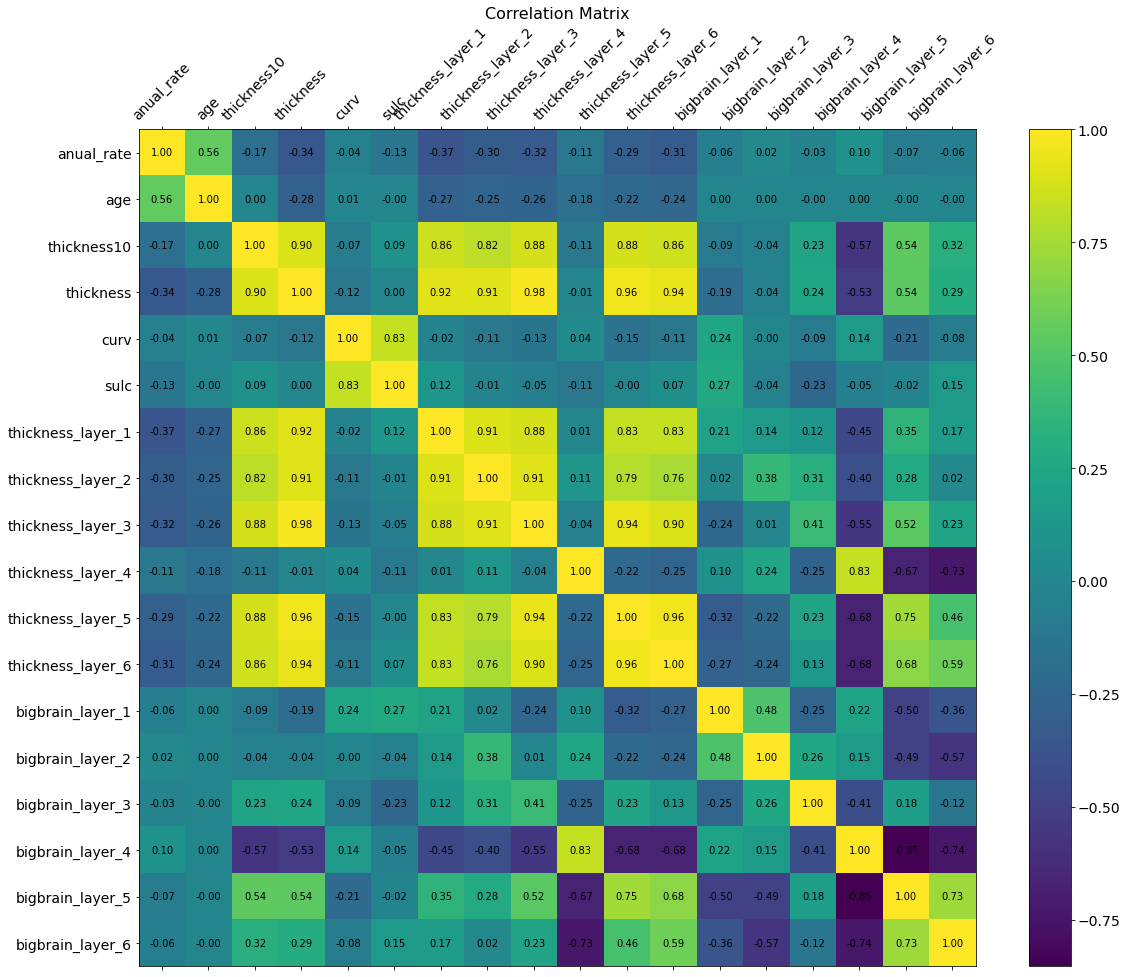

In [17]:
df2corr = df1[['anual_rate','age','thickness10','thickness','curv', 'sulc',
              'thickness_layer_1','thickness_layer_2','thickness_layer_3',
              'thickness_layer_4','thickness_layer_5','thickness_layer_6',
              'bigbrain_layer_1','bigbrain_layer_2','bigbrain_layer_3',
              'bigbrain_layer_4','bigbrain_layer_5','bigbrain_layer_6']]

f = plt.figure(figsize=(19, 15))
s = 14
data = df2corr.corr()
plt.matshow(data, fignum=f.number)
for (x, y), value in np.ndenumerate(data):
    plt.text(x, y, f"{value:.2f}", va="center", ha="center")
plt.xticks(range(df2corr.select_dtypes(['number']).shape[1]), df2corr.select_dtypes(['number']).columns, fontsize=s, rotation=45)
plt.yticks(range(df2corr.select_dtypes(['number']).shape[1]), df2corr.select_dtypes(['number']).columns, fontsize=s)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=s)
plt.title('Correlation Matrix', fontsize=16);

In [18]:
features_sets = [#['age'],
                 #['age','macro_area'],
                 #['age','thickness10'],
                 #['age','thickness'],
                 #['age','curv'],
                 #['age','sulc'],
                 #['age','hemisphere'],
                 ['age','bigbrain_layer_1'],
                 #['age','bigbrain_layer_2'],
                 #['age','bigbrain_layer_3'],
                 #['age','bigbrain_layer_4'],
                 #['age','bigbrain_layer_5'],
                 #['age','bigbrain_layer_6'],
                 
                 ['age','thickness10','macro_area', 'sulc','hemisphere',
                  'bigbrain_layer_1','bigbrain_layer_2','bigbrain_layer_3',
                  'bigbrain_layer_4','bigbrain_layer_5','bigbrain_layer_6', 'atlasEcono'],
    
                 ['age','thickness10','macro_area', 'curv',
                  'thickness_layer_1','thickness_layer_2','thickness_layer_3',
                  'thickness_layer_4','thickness_layer_5',],

    
                 ['age','thickness10','macro_area','curv', 'sulc', 'hemisphere',
                  'thickness_layer_1','thickness_layer_2','thickness_layer_3',
                  'thickness_layer_4','thickness_layer_5','thickness_layer_6', 'atlasEcono'],
    
                 ['age','thickness10','macro_area','curv', 'sulc',
                  'thickness_layer_1','thickness_layer_2','thickness_layer_3',
                  'thickness_layer_4','thickness_layer_5'],
                 
                 ['age','thickness10','macro_area',
                  'bigbrain_layer_1','bigbrain_layer_2',
                  'bigbrain_layer_4','bigbrain_layer_5',],
    
                 ['age','thickness10','macro_area',
                  'bigbrain_layer_1','bigbrain_layer_2','bigbrain_layer_3',
                  'bigbrain_layer_4','bigbrain_layer_5','bigbrain_layer_6'],
    
                 ['age','curv',
                  'bigbrain_layer_1','bigbrain_layer_2','bigbrain_layer_3',
                  'bigbrain_layer_4','bigbrain_layer_5','bigbrain_layer_6'],
                 
                 ['age','thickness10','macro_area','thickness','curv',
                  'bigbrain_layer_1','bigbrain_layer_2','bigbrain_layer_3',
                  'bigbrain_layer_4','bigbrain_layer_5'],

                 ['age','thickness10','macro_area','thickness','sulc',
                  'bigbrain_layer_1','bigbrain_layer_2','bigbrain_layer_3',
                  'bigbrain_layer_4','bigbrain_layer_5', 'bigbrain_layer_6'],
                 
                 ['age','thickness10','macro_area','bigbrain_layer_1'],
                 ['age','thickness10','bigbrain_layer_1']
                ]

In [23]:
df1.dtypes

age                       int64
hemisphere              float64
atlasEcono              float64
area                    float32
curv                    float32
sulc                    float32
thickness               float32
sex                     float64
handedness              float64
macro_area              float32
ve_1                    float32
ve_2                    float32
ve_3                    float32
ve_4                    float32
ve_5                    float32
ve_6                    float32
bigbrain_layer_1        float32
bigbrain_layer_2        float32
bigbrain_layer_3        float32
bigbrain_layer_4        float32
bigbrain_layer_5        float32
bigbrain_layer_6        float32
bigbrain_layer_1_r      float32
bigbrain_layer_2_r      float32
bigbrain_layer_3_r      float32
bigbrain_layer_4_r      float32
bigbrain_layer_5_r      float32
bigbrain_layer_6_r      float32
bblayer1_age            float32
bblayer2_age            float32
bblayer3_age            float32
bblayer4

#### 2.4. Model Training and Testing

In [19]:
inexplicable_strutures = {}
for key in pd.Series([x[1:] for x in df1.h_structure.unique()]).unique():
    inexplicable_strutures[key]=0
    
list_performance = []
testes = []
shap_info = []

for features in tqdm(features_sets):    

    X = df1[features]
    y = df1.anual_rate
    performance = []
    for struture in tqdm(set([x[1:] for x in df1.h_structure.unique()])):

        # Train Test Split
        test_index = df1[(df1.h_structure=='1'+struture)|(df1.h_structure=='0'+struture)].index
        train_index = set(df1.index)-set(test_index)
        X_train = X.loc[train_index]
        X_test = X.loc[test_index]
        y_train = y.loc[train_index]
        y_test = y.loc[test_index]
        
        # Model Train
        lgbm = LGBMRegressor()
        print("treino começado")
        lgbm.fit(X_train, y_train) #categorical_feature = [2]
        print("treino finalizado")
        
        # Model Test
        y_pred = lgbm.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        
        # SHAP
        explainer = shap.TreeExplainer(lgbm)
        shap_values_ = explainer.shap_values(X_train[features])
        pd.DataFrame(shap_values_).mad(axis=0)
        expected_value = explainer.expected_value
        
        # Save Performance
        performance.append([struture,r2]+list(pd.DataFrame(shap_values_).mad(axis=0)))
    
    # Save SHAP
    shap_info.append([[features], shap_values_, X_train, expected_value])
    
    # Ajust and save to List of all Performance
    performance = pd.DataFrame(performance).sort_values(by=1, ascending=False)
    performance.columns = ['struture','r2']+features
    performance['features'] = [features]*len(performance)
    list_performance.append(performance)
    
    # Handling Inexplicable strutures
    for key in performance[performance.r2<0.5].struture:
        inexplicable_strutures[key]=inexplicable_strutures[key]+1
    testes.append([features, performance.mean()[1], performance[performance.r2>0.5].mean()[1], len(performance[performance.r2<0.5])])
    
# Finishing
testes = pd.DataFrame(testes).rename(columns={0:'features',1:'r2_all',2:'r2_clean',3:'inexplicable_strutures'})

  0%|          | 0/12 [00:00<?, ?it/s]

treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começad

  8%|▊         | 1/12 [00:24<04:27, 24.29s/it]

treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começad

 17%|█▋        | 2/12 [00:53<04:32, 27.27s/it]

treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começad

 25%|██▌       | 3/12 [01:24<04:20, 28.90s/it]

treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começad

 33%|███▎      | 4/12 [01:57<04:05, 30.70s/it]

treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começad

 42%|████▏     | 5/12 [02:29<03:37, 31.07s/it]

treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começad

 50%|█████     | 6/12 [02:57<02:59, 30.00s/it]

treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começad

 58%|█████▊    | 7/12 [03:25<02:26, 29.20s/it]

treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começad

 67%|██████▋   | 8/12 [03:56<01:59, 29.78s/it]

treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começad

 75%|███████▌  | 9/12 [04:27<01:30, 30.16s/it]

treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começad

 83%|████████▎ | 10/12 [04:56<00:59, 29.95s/it]

treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começad

 92%|█████████▏| 11/12 [05:22<00:28, 28.68s/it]

treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começado
treino finalizado
treino começad

100%|██████████| 12/12 [05:45<00:00, 28.82s/it]


#### 2.4. Model Evaluation

In [20]:
testes

features  \
0                                                                                                                                                                [age, bigbrain_layer_1]   
1               [age, thickness10, macro_area, sulc, hemisphere, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6, atlasEcono]   
2                                                    [age, thickness10, macro_area, curv, thickness_layer_1, thickness_layer_2, thickness_layer_3, thickness_layer_4, thickness_layer_5]   
3   [age, thickness10, macro_area, curv, sulc, hemisphere, thickness_layer_1, thickness_layer_2, thickness_layer_3, thickness_layer_4, thickness_layer_5, thickness_layer_6, atlasEcono]   
4                                              [age, thickness10, macro_area, curv, sulc, thickness_layer_1, thickness_layer_2, thickness_layer_3, thickness_layer_4, thickness_layer_5]   
5                                                                                 [age, thickness10, macro_area, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_4, bigbrain_layer_5]   
6                                             [age, thickness10, macro_area, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6]   
7                                                                [age, curv, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6]   
8                                              [age, thickness10, macro_area, thickness, curv, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5]   
9                            [age, thickness10, macro_area, thickness, sulc, bigbrain_layer_1, bigbrain_layer_2, bigbrain_layer_3, bigbrain_layer_4, bigbrain_layer_5, bigbrain_layer_6]   
10                                                                                                                                      [age, thickness10, macro_area, bigbrain_layer_1]   
11                                                                                                                                                  [age, thickness10, bigbrain_layer_1]   

      r2_all  r2_clean  inexplicable_strutures  
0   0.248882  0.783716                      10  
1   0.620269  0.861901                       7  
2   0.308092  0.850337                       5  
3   0.446164  0.834500                       5  
4   0.293007  0.836870                       5  
5   0.651741  0.857771                       6  
6   0.651665  0.856556                       6  
7   0.556671  0.865529                       9  
8   0.664100  0.878717                       6  
9   0.618413  0.873783                       7  
10  0.624433  0.833124                       7  
11  0.505271  0.815740                       8

In [ ]:
pd.DataFrame.from_dict(inexplicable_strutures, orient='index').sort_values(0, ascending=False)

## 3. Explicabilidade

In [ ]:
pd.concat(list_performance, axis=0).mean().sort_values()

-----------

In [ ]:
n=2
shap.summary_plot(shap_info[n][1], 
                  feature_names =shap_info[n][0][0],
                  plot_type='bar'
                 )

In [ ]:
# Referencia
plt.figure(figsize=(10,5))
plt.title('Variação na Espessura por idade')
for i in range(76):
    plt.scatter(taxa_anual.columns, taxa_anual.iloc[i], alpha=0.4, c=taxa_anual.columns, cmap=plt.cm.magma, s=20)
    plt.xlim(5,85)
    plt.ylim(-0.055,0.01)
plt.show()

In [ ]:
taxa_anual.index

In [ ]:
# handling inexplicables
inexplicables = list_performance[n][list_performance[n].r2<0.5].struture.to_list()
inexplicables_index = []
for i in inexplicables:
    inexplicables_index.extend(df1[(df1.h_structure=='1'+struture)|(df1.h_structure=='0'+struture)].index)

# axis X 
df4 = shap_info[n][2]
df4 = df4.drop(index=inexplicables_index, errors='ignore')

# axis Y
df3 = pd.DataFrame(shap_info[n][1] + shap_info[n][3]) # mudando baseline
df3.columns= shap_info[n][0]
df3.index = df4.index
df3 = df3.drop(index=inexplicables_index, errors='ignore')    
    
for f in shap_info[n][0][0]:
    
    # regressao polionomial
    z = np.polyfit(df4[f], [a[0] for a in df3[f].values], 3)
    p = np.poly1d(z)
    xp = np.linspace(df4[f].min(), df4[f].max(), 100)
    
    # referencia
    mean_mean_shap = df3.describe().mean(axis=1)[1]
    mean_std_shap = df3.describe().mean(axis=1)[2]
    init = mean_mean_shap + mean_std_shap/2
    final = mean_mean_shap - mean_std_shap/2
    
    # plot
    plt.figure(figsize=(10,5))
    plt.title(f)
    _ = plt.plot(xp, p(xp), '-',)
    plt.fill_between([df4[f].min(), df4[f].max()], init, final, alpha=.05)
    plt.scatter(df4[f], df3[f],c=df4.age, cmap=plt.cm.magma, s=20)
    plt.show()

In [ ]:
# handling inexplicables
inexplicables = list_performance[n][list_performance[n].r2<0.5].struture.to_list()
inexplicables_index = []
for i in inexplicables:
    inexplicables_index.extend(df1[(df1.h_structure=='1'+struture)|(df1.h_structure=='0'+struture)].index)

# axis X 
df4 = shap_info[n][2]
df4 = df4.drop(index=inexplicables_index, errors='ignore')

# axis Y
df3 = pd.DataFrame(shap_info[n][1] + shap_info[n][3]) # mudando baseline
df3.columns= shap_info[n][0]
df3.index = df4.index
df3 = df3.drop(index=inexplicables_index, errors='ignore')    
    
for f in shap_info[n][0][0]:
    
    # regressao polionomial
    z = np.polyfit(df4[f], [a[0] for a in df3[f].values], 3)
    p = np.poly1d(z)
    xp = np.linspace(df4[f].min(), df4[f].max(), 100)
    
    # referencia
    mean_mean_shap = df3.describe().mean(axis=1)[1]
    mean_std_shap = df3.describe().mean(axis=1)[2]
    init = mean_mean_shap + mean_std_shap/2
    final = mean_mean_shap - mean_std_shap/2
    
    # plot
    plt.figure(figsize=(10,5))
    plt.title(f)
    _ = plt.plot(xp, p(xp), '-',)
    plt.fill_between([df4[f].min(), df4[f].max()], init, final, alpha=.05)
    plt.scatter(df4[f], df3[f],c=df4.macro_area, cmap=plt.cm.viridis, s=20)
    plt.show()

NotFittedError: No booster found. Need to call fit beforehand.

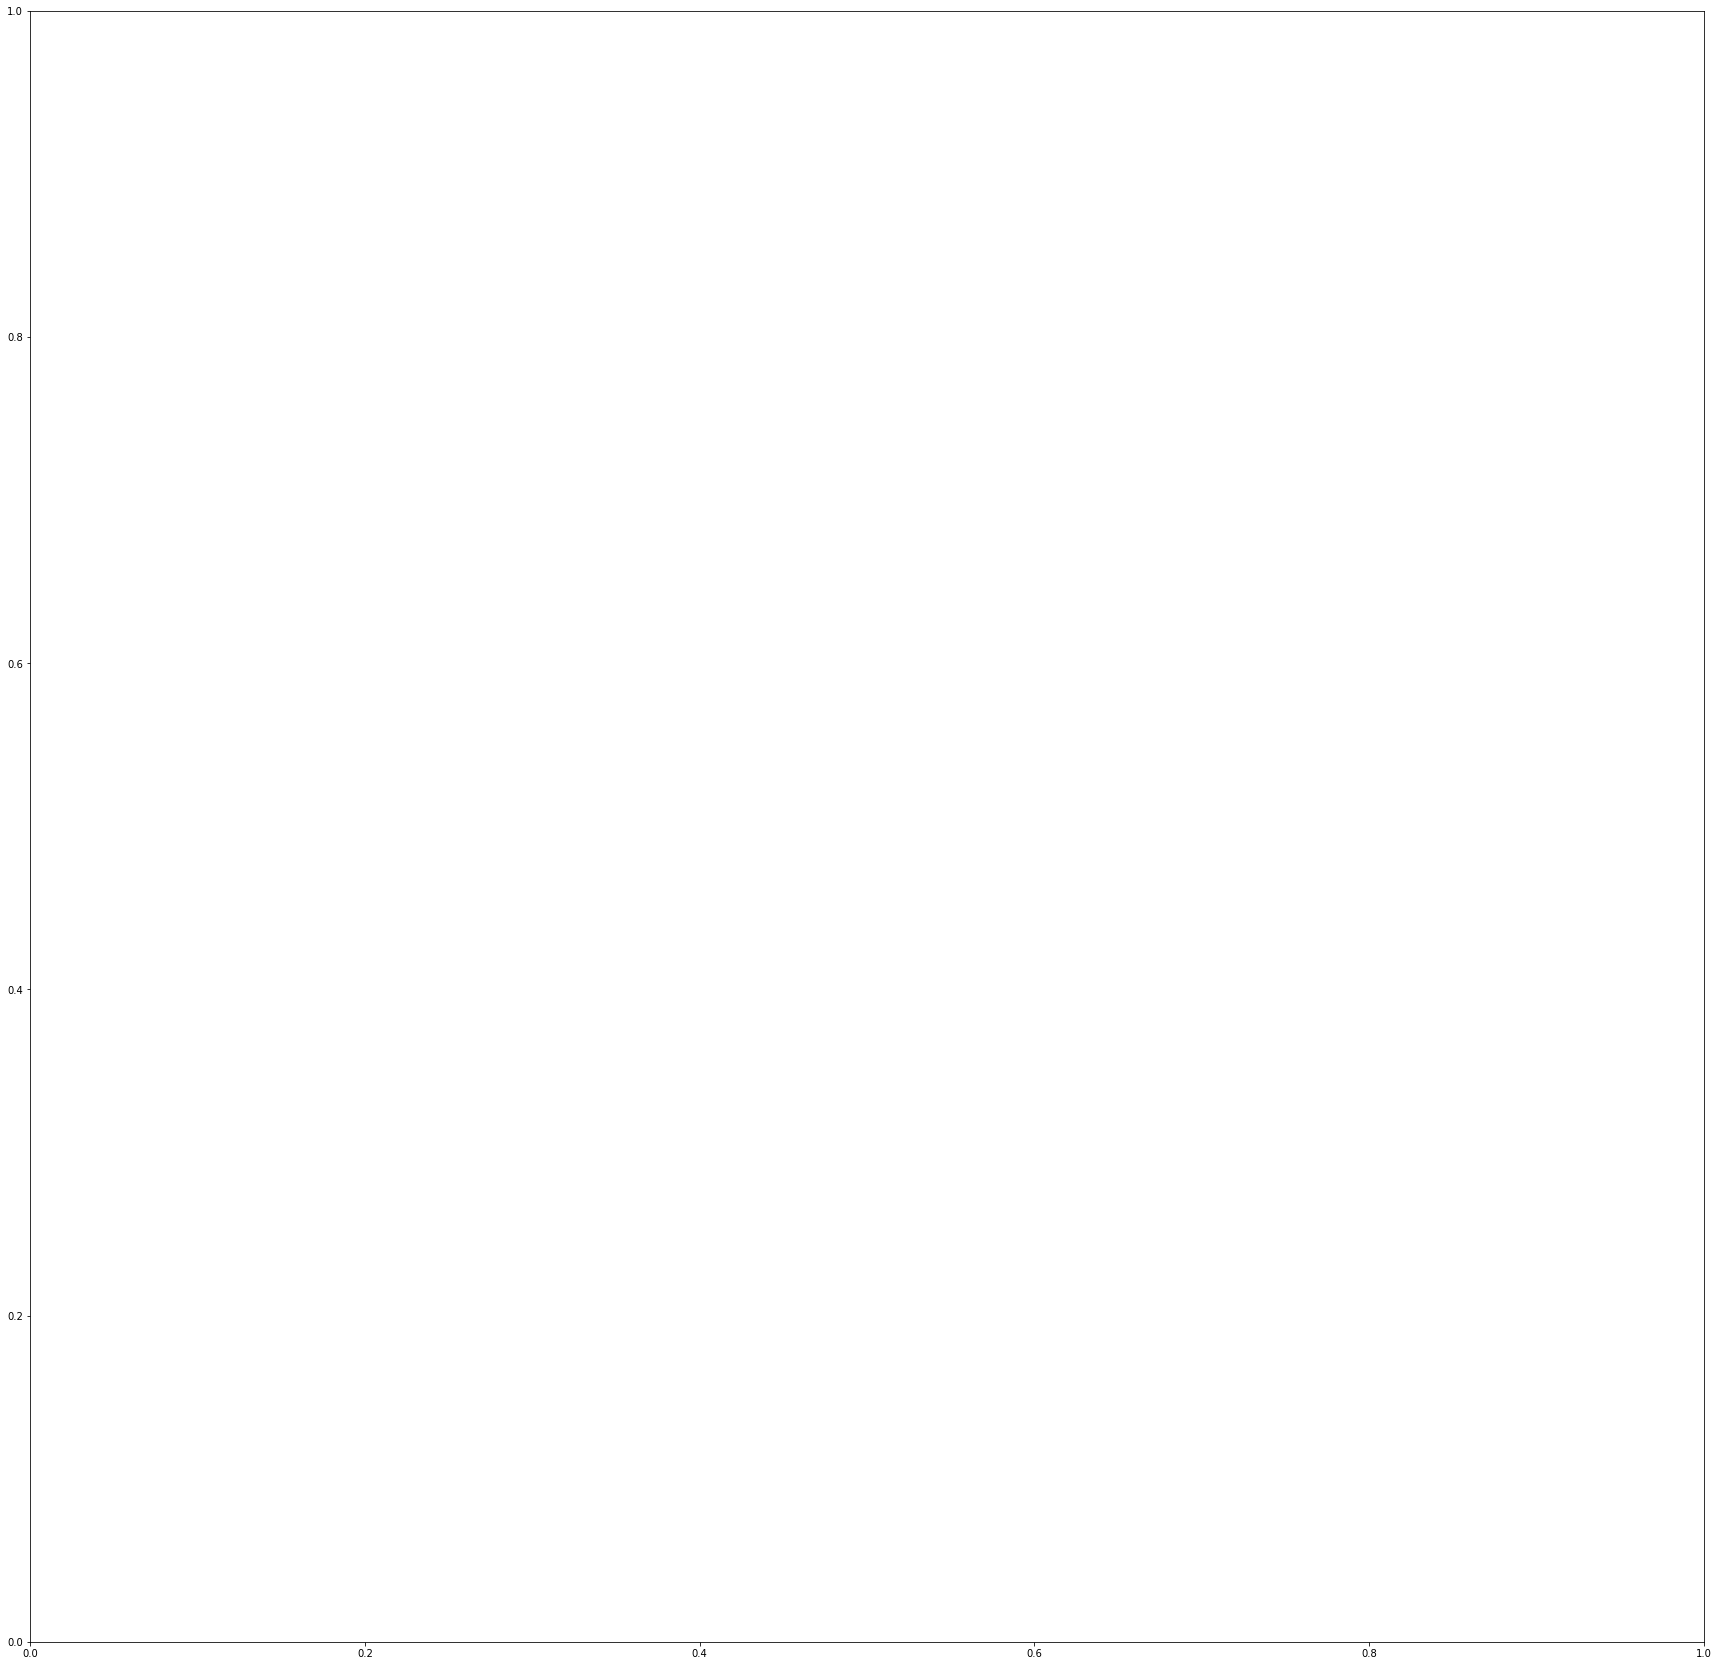

In [136]:
plot_tree(lgbm, figsize = (30,30), 
          show_info = ['split_gain','internal_value','internal_count','data_percentage','leaf_count',])         

-------------

## 4. ToDo

-------------

## 5. Old but important Code

#### 5.1. Criando anualrate.parquet

In [ ]:
# freesufer data
mri_subs_all = pp.read_parquet(mri_subs_path)

# sample, drop zeros and encode cats
mri_subs = pp.clean(mri_subs_all)

# quality assessment
bad_participants = pp.find_bad_ones(mri_areas_path)
mri_subs = pp.eliminate_bad_ones(bad_participants, mri_subs)

# add identification features
mri_subs = pp.cat2int(mri_subs, cat_features=['sex', 'handedness', 'hemisphere'])

# add h_structure
mri_subs['h_structure'] = mri_subs.hemisphere.astype(str) + mri_subs.atlasEcono.astype(str)

#dict_groupby = {}
keys = mri_subs.drop(columns=['atlasDF', 'h_structure']).columns
for key in keys:
    dict_groupby[key] = []
dict_groupby['h_structure'] = []

for i, participant in enumerate(mri_subs.participant.unique()):
    
    df = mri_subs[mri_subs.participant == participant].groupby(['h_structure']).mean()
    df['participant_i'] = i
    df['participant'] = participant
    print(i)
    
    for key in keys:
        dict_groupby[key].extend(df[key])
    dict_groupby['h_structure'].extend(df.index)

df0 = pd.DataFrame(dict_groupby)
df0

df0.to_parquet("/home/brunovieira/Tamires_Experiments/Bases_de_Dados/MRI_2_anualrate_894_v2.parquet")

In [3]:
# freesufer data
mri_subs_all = pp.read_parquet(mri_subs_path)
print('freesufer data')

# sample, drop zeros and encode cats
mri_subs = pp.clean(mri_subs_all)
print('sample, drop zeros and encode cats')

# quality assessment
bad_participants = pp.find_bad_ones(mri_areas_path)
mri_subs = pp.eliminate_bad_ones(bad_participants, mri_subs)
print('quality assessment')

# add identification features
mri_subs = pp.cat2int(mri_subs, cat_features=['sex', 'handedness', 'hemisphere'])
print('add identification features')

# add h_atlasDF
mri_subs['h_atlasDF'] = mri_subs.hemisphere.astype(str) + mri_subs.atlasDF.astype(str)
print('add h_atlasDF')

# create dict_groupby 
dict_groupby = {}
keys = mri_subs.drop(columns=['atlasDF', 'h_atlasDF']).columns
for key in keys:
    dict_groupby[key] = []
dict_groupby['h_atlasDF'] = []
print('create dict_groupby')

for i, participant in enumerate(mri_subs.participant.unique()):
    
    df = mri_subs[mri_subs.participant == participant].groupby(['h_atlasDF']).mean()
    df['participant_i'] = i
    df['participant'] = participant
    print(i)
    
    for key in keys:
        dict_groupby[key].extend(df[key])
    dict_groupby['h_atlasDF'].extend(df.index)

df0 = pd.DataFrame(dict_groupby)
df0

#df0.to_parquet("/home/brunovieira/Tamires_Experiments/Bases_de_Dados/MRI_2_anualrate_894_v2.parquet")

freesufer data
sample, drop zeros and encode cats
quality assessment
add identification features
add h_atlasDF
create dict_groupby
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244

participant  hemisphere  atlasEcono      area      curv      sulc  \
0       A00008326         0.0    3.790049  0.633183 -0.001802  4.238084   
1       A00008326         0.0   18.155577  0.601876 -0.008262  0.125957   
2       A00008326         0.0   30.922288  0.656662 -0.042081 -2.089579   
3       A00008326         0.0    9.359746  0.673776 -0.049637 -1.078827   
4       A00008326         0.0   28.972928  0.682724 -0.029710 -0.314644   
...           ...         ...         ...       ...       ...       ...   
55740   A00074034         1.0   27.800720  0.612191 -0.076858 -2.278778   
55741   A00074034         1.0   20.743590  0.743309 -0.054838 -4.678692   
55742   A00074034         1.0   40.880812  0.669733 -0.060874  1.066757   
55743   A00074034         1.0   35.931890  0.683689 -0.043937  0.511255   
55744   A00074034         1.0   42.105371  0.659898 -0.081408 -0.644637   

       thickness   age  sex  handedness h_atlasDF  
0       2.969881  59.0  0.0         2.0       0-1  
1       2.703677  59.0  0.0         2.0       010  
2       2.515563  59.0  0.0         2.0       011  
3       2.724164  59.0  0.0         2.0       012  
4       1.864753  59.0  0.0         2.0       013  
...          ...   ...  ...         ...       ...  
55740   2.362472  10.0  0.0         2.0        15  
55741   3.448317  10.0  0.0         2.0        16  
55742   3.026673  10.0  0.0         2.0        17  
55743   2.803049  10.0  0.0         2.0        18  
55744   3.159884  10.0  0.0         2.0        19  

[55745 rows x 11 columns]

In [6]:
df0.to_parquet("/home/brunovieira/Tamires_Experiments/Bases_de_Dados/MRI_2_anualrate_894_v2.parquet")

#### 5.2. Criando Age_Stable.csv

In [ ]:
#derivada = taxa_anual.idxmax(axis=1)
#derivada = derivada.reset_index()
#derivada['hemisferio'] = [a[0] for a in derivada['atlasEcono']]
#derivada['atlasEcono'] = [a[1:] for a in derivada['atlasEcono']]
#derivada['bigest_slope'] = np.array(taxa_anual.min(axis=1))
#derivada = derivada.rename(columns={'atlasEcono':'econo',0:'age_stable'})
#derivada.to_csv('/home/brunovieira/Tamires_Experiments/Bases_de_Dados/Age_Stable.csv')

5.3 Rascunho

In [ ]:
# Referencia
plt.figure(figsize=(10,5))
plt.title('Variação na Espessura por idade')
for i in range(76):
    plt.scatter(taxa_anual.index, taxa_anual.iloc[i], alpha=0.4, c=taxa_anual.index, cmap=plt.cm.viridis, s=20)
    plt.xlim(5,85)
    plt.ylim(-0.055,0.01)
plt.show()